In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 4
2023-08-16 07:55:23.633907


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.0065)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-2.3922)
penalty_target_min tensor(-11.0972) penalty_target_max tensor(10.5368)
train_loss:  -7.944463903427125
valid_loss:  -7.560206010437012
h_min_tilde -11.097233 ell_tilde -7.8676123248291026 kappa_tilde 0.00027822378735638064


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.567772626876831

 2 3.454361915588379

 3 3.380249261856079

 4 3.456061363220215

 5 3.4151611328125

 6 3.37605357170105

 7 3.4649064540863037

 8 3.36458158493042

 9 3.485823392868042

 10 3.3852415084838867

 11 3.310732841491699

 12 3.393357992172241

 13 3.412080764770508

 14 3.3411824703216553

 15 3.294644832611084

 16 3.363619327545166

 17 3.4109034538269043

 18 3.5517847537994385

 19 3.5135300159454346

 20 3.3717029094696045

 21 3.567633628845215

 22 4.7683751583099365

 23 5.1432600021362305

 24 3.496030330657959

 25 3.635819435119629

 26 3.4108078479766846

 27 3.6178343296051025

 28 3.6225335597991943

 29 3.5179309844970703

 30 6.715287923812866

 31 7.1784539222717285

 32 7.350849866867065

 33 7.317184209823608

 34 7.288570404052734

 35 7.33186936378479

 36 4.362755060195923

 37 3.697629451751709

 38 3.623654365539551

 39 3.706077814102173

 40 3.4941329956054688

 41 5.695103406906128

 42 6.404574871063232

 43 3.4844346046447754

 44 3.74

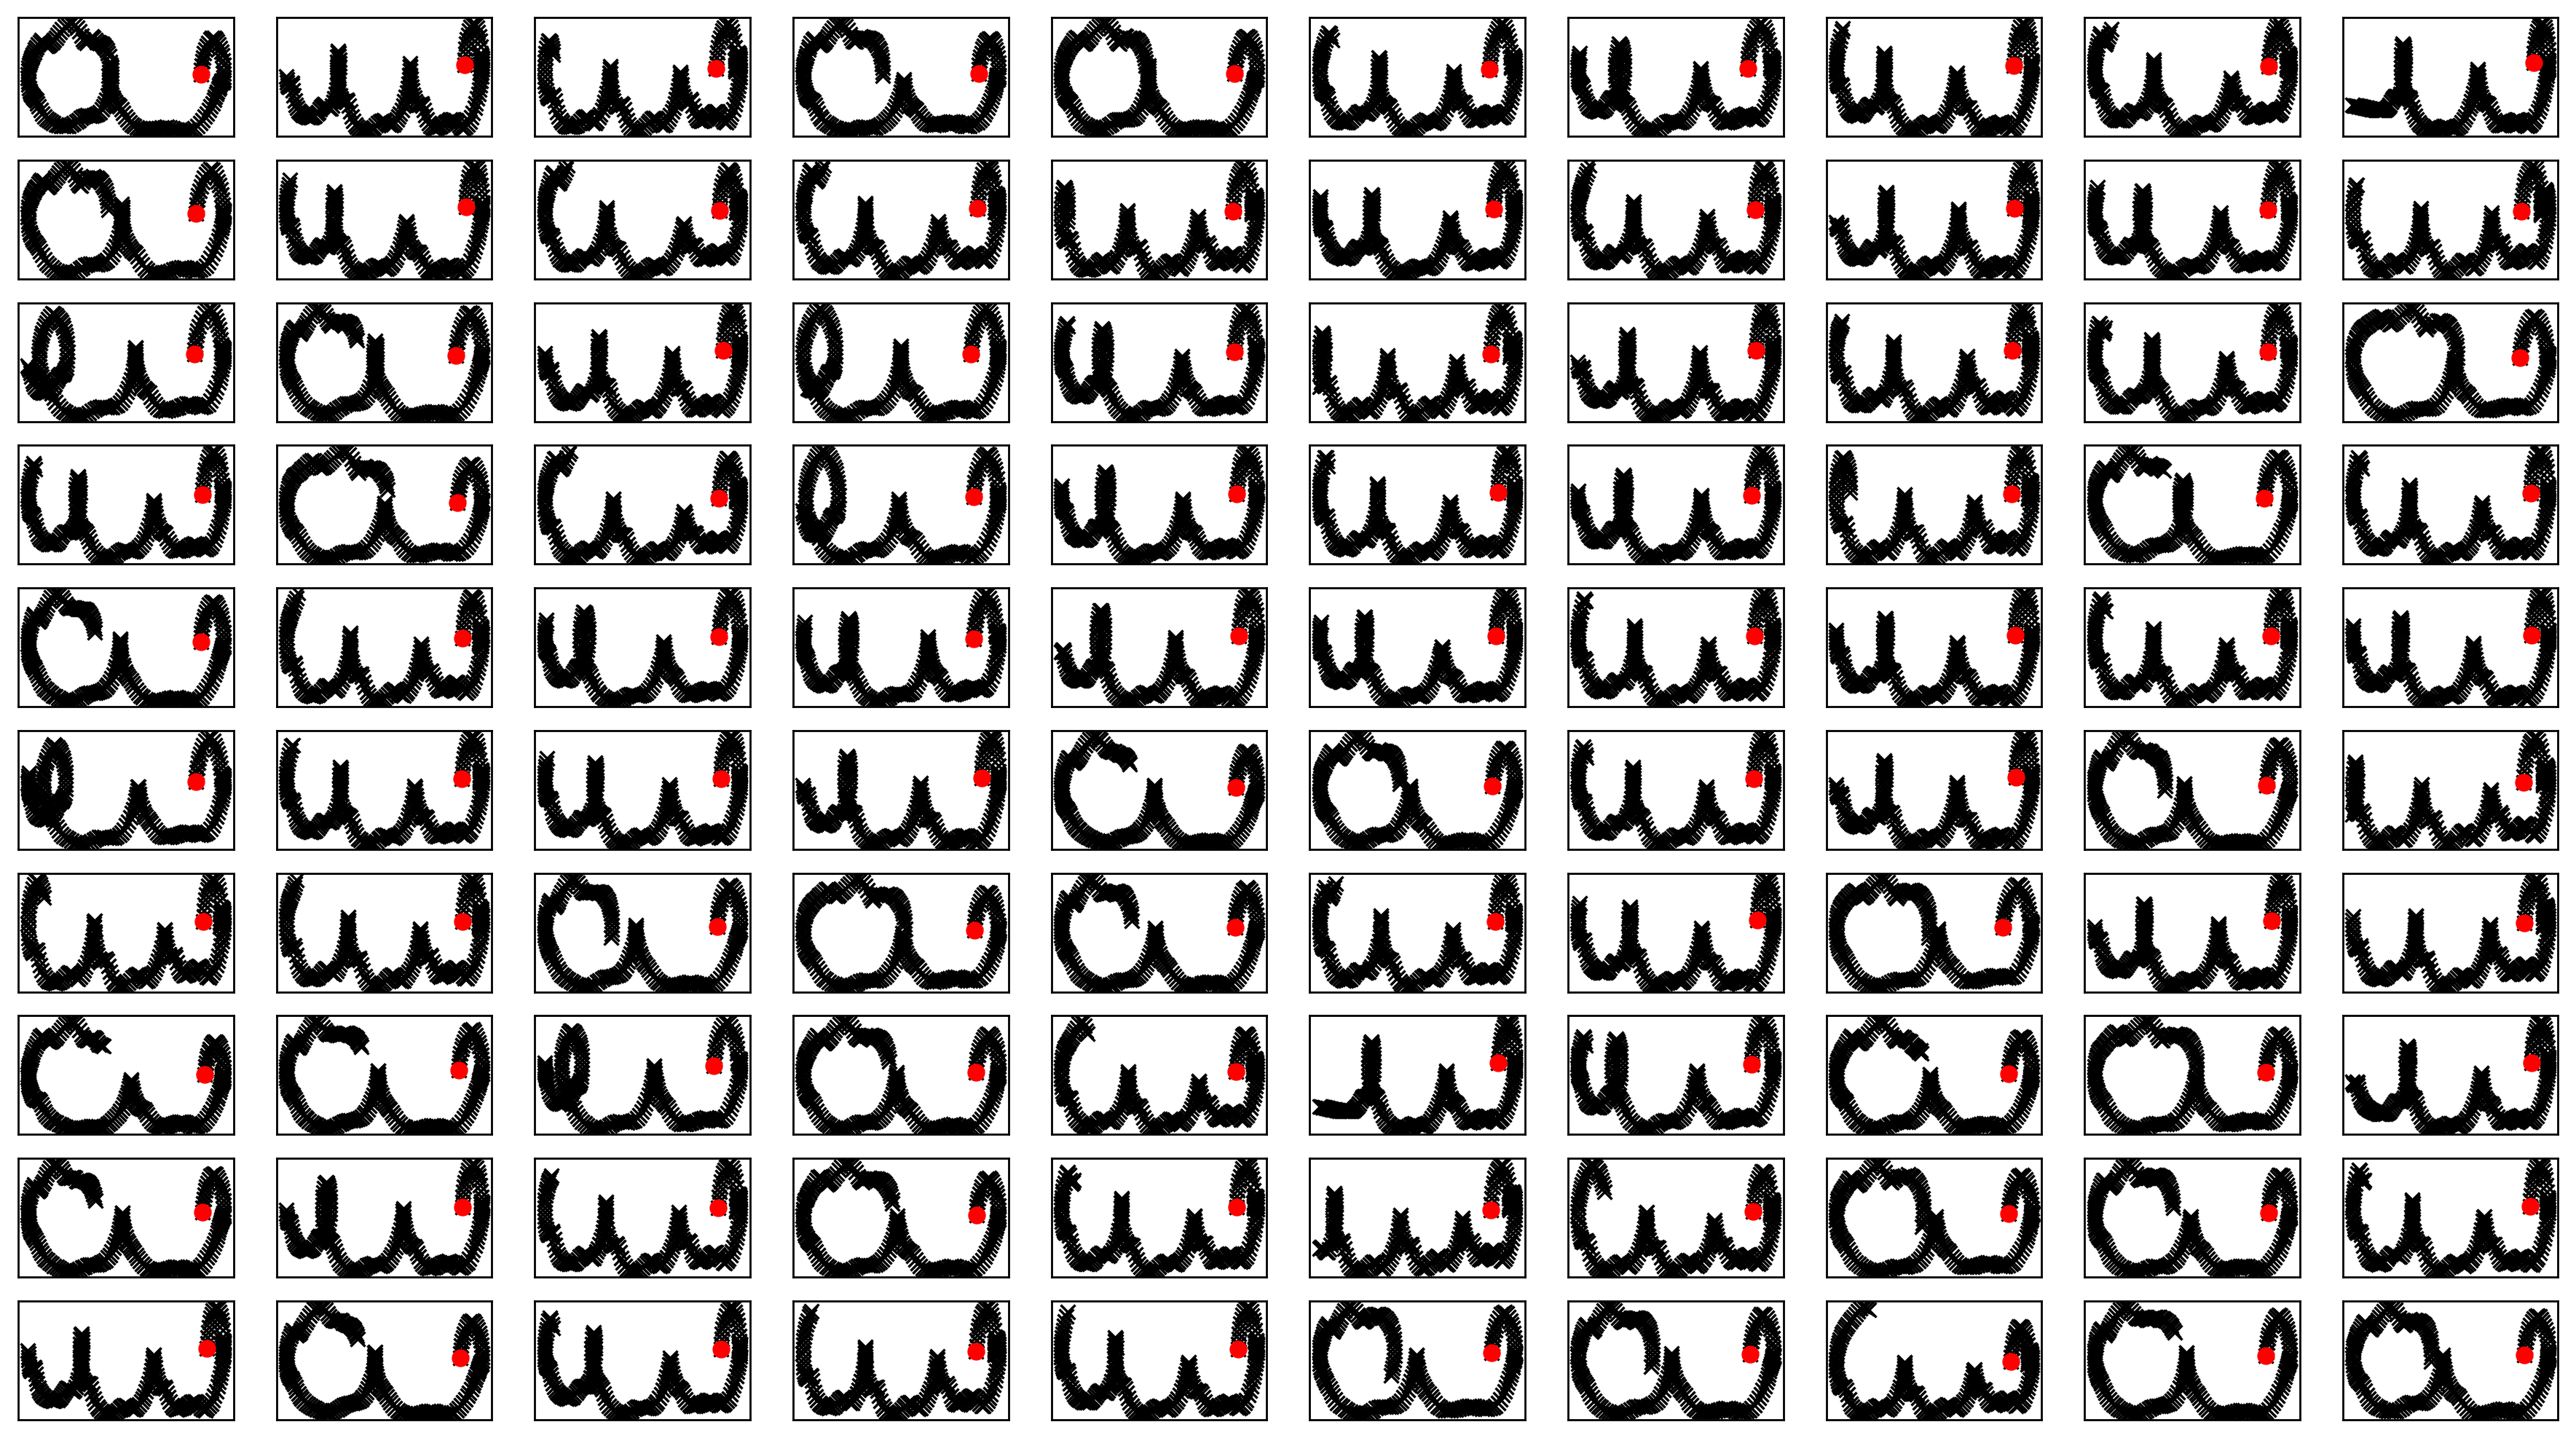

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

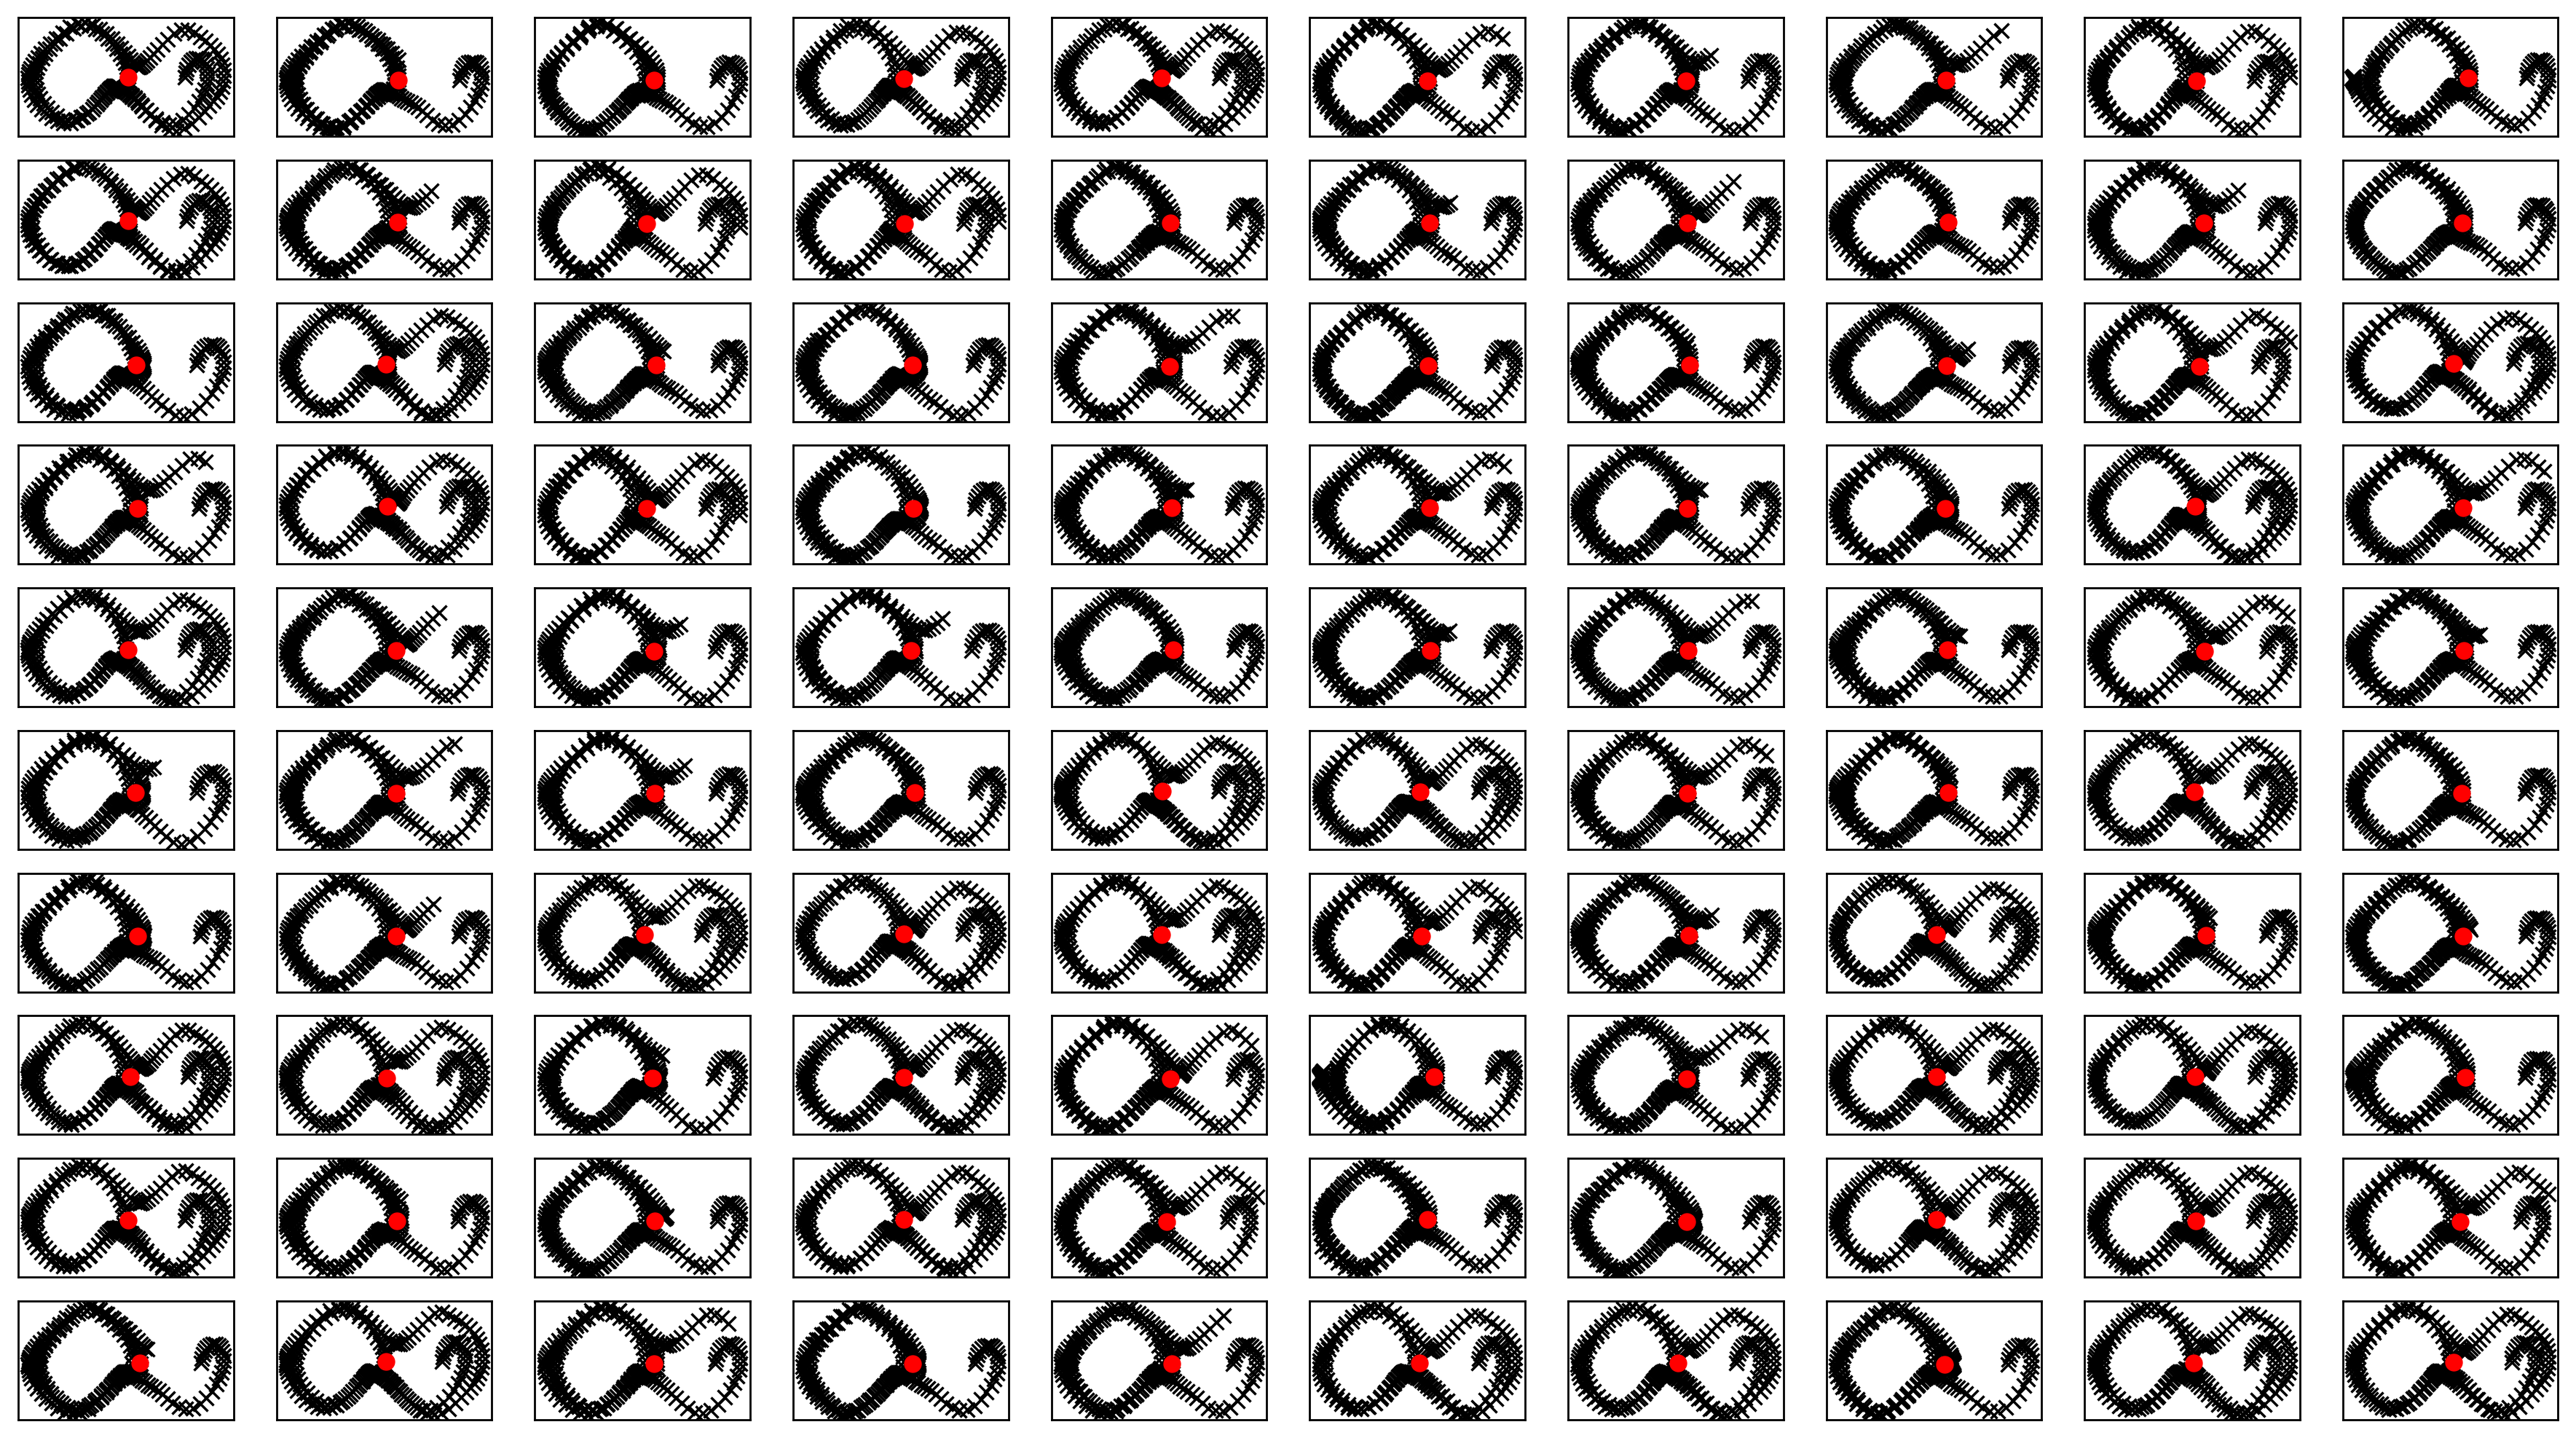

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-08-16 08:02:48.122560


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.35344  validloss 1.45383±0.00000  bestvalidloss 1.45383  last_update 0
train: iter 1  trainloss 1.22302  validloss 1.31902±0.00000  bestvalidloss 1.31902  last_update 0
train: iter 2  trainloss 1.14984  validloss 1.28111±0.00000  bestvalidloss 1.28111  last_update 0
train: iter 3  trainloss 1.11414  validloss 1.25570±0.00000  bestvalidloss 1.25570  last_update 0
train: iter 4  trainloss 1.08300  validloss 1.21978±0.00000  bestvalidloss 1.21978  last_update 0
train: iter 5  trainloss 1.04859  validloss 1.17321±0.00000  bestvalidloss 1.17321  last_update 0
train: iter 6  trainloss 1.01310  validloss 1.13674±0.00000  bestvalidloss 1.13674  last_update 0
train: iter 7  trainloss 0.97466  validloss 1.06486±0.00000  bestvalidloss 1.06486  last_update 0
train: iter 8  trainloss 0.93673  validloss 0.99714±0.00000  bestvalidloss 0.99714  last_update 0
train: iter 9  trainloss 0.90790  validloss 0.95088±0.00000  bestvalidloss 0.95088  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.51001  validloss 0.52475±0.00000  bestvalidloss 0.49213  last_update 1
train: iter 84  trainloss 0.51441  validloss 0.49067±0.00000  bestvalidloss 0.49067  last_update 0
train: iter 85  trainloss 0.50845  validloss 0.49552±0.00000  bestvalidloss 0.49067  last_update 1
train: iter 86  trainloss 0.51852  validloss 0.50123±0.00000  bestvalidloss 0.49067  last_update 2
train: iter 87  trainloss 0.51059  validloss 0.50556±0.00000  bestvalidloss 0.49067  last_update 3
train: iter 88  trainloss 0.51012  validloss 0.49900±0.00000  bestvalidloss 0.49067  last_update 4
train: iter 89  trainloss 0.49604  validloss 0.48802±0.00000  bestvalidloss 0.48802  last_update 0
train: iter 90  trainloss 0.50026  validloss 0.51023±0.00000  bestvalidloss 0.48802  last_update 1
train: iter 91  trainloss 0.49856  validloss 0.48939±0.00000  bestvalidloss 0.48802  last_update 2
train: iter 92  trainloss 0.49979  validloss 0.50393±0.00000  bestvalidloss 0.48802  last_update 3
train: ite

train: iter 166  trainloss 0.46350  validloss 0.46697±0.00000  bestvalidloss 0.43869  last_update 4
train: iter 167  trainloss 0.44822  validloss 0.43778±0.00000  bestvalidloss 0.43778  last_update 0
train: iter 168  trainloss 0.45304  validloss 0.47121±0.00000  bestvalidloss 0.43778  last_update 1
train: iter 169  trainloss 0.45114  validloss 0.44156±0.00000  bestvalidloss 0.43778  last_update 2
train: iter 170  trainloss 0.44872  validloss 0.46010±0.00000  bestvalidloss 0.43778  last_update 3
train: iter 171  trainloss 0.44427  validloss 0.45189±0.00000  bestvalidloss 0.43778  last_update 4
train: iter 172  trainloss 0.44029  validloss 0.44057±0.00000  bestvalidloss 0.43778  last_update 5
train: iter 173  trainloss 0.45246  validloss 0.46421±0.00000  bestvalidloss 0.43778  last_update 6
train: iter 174  trainloss 0.43876  validloss 0.43714±0.00000  bestvalidloss 0.43714  last_update 0
train: iter 175  trainloss 0.43856  validloss 0.43323±0.00000  bestvalidloss 0.43323  last_update 0


train: iter 248  trainloss 0.42030  validloss 0.41333±0.00000  bestvalidloss 0.40383  last_update 10
train: iter 249  trainloss 0.41532  validloss 0.40430±0.00000  bestvalidloss 0.40383  last_update 11
train: iter 250  trainloss 0.42608  validloss 0.40068±0.00000  bestvalidloss 0.40068  last_update 0
train: iter 251  trainloss 0.41287  validloss 0.42879±0.00000  bestvalidloss 0.40068  last_update 1
train: iter 252  trainloss 0.42307  validloss 0.44353±0.00000  bestvalidloss 0.40068  last_update 2
train: iter 253  trainloss 0.41385  validloss 0.40322±0.00000  bestvalidloss 0.40068  last_update 3
train: iter 254  trainloss 0.42248  validloss 0.40107±0.00000  bestvalidloss 0.40068  last_update 4
train: iter 255  trainloss 0.41251  validloss 0.41136±0.00000  bestvalidloss 0.40068  last_update 5
train: iter 256  trainloss 0.40796  validloss 0.40605±0.00000  bestvalidloss 0.40068  last_update 6
train: iter 257  trainloss 0.40804  validloss 0.40161±0.00000  bestvalidloss 0.40068  last_update 

train: iter 330  trainloss 0.40516  validloss 0.42497±0.00000  bestvalidloss 0.38436  last_update 6
train: iter 331  trainloss 0.39731  validloss 0.39027±0.00000  bestvalidloss 0.38436  last_update 7
train: iter 332  trainloss 0.39474  validloss 0.40143±0.00000  bestvalidloss 0.38436  last_update 8
train: iter 333  trainloss 0.40695  validloss 0.38906±0.00000  bestvalidloss 0.38436  last_update 9
train: iter 334  trainloss 0.40016  validloss 0.42367±0.00000  bestvalidloss 0.38436  last_update 10
train: iter 335  trainloss 0.39873  validloss 0.40089±0.00000  bestvalidloss 0.38436  last_update 11
train: iter 336  trainloss 0.39199  validloss 0.42789±0.00000  bestvalidloss 0.38436  last_update 12
train: iter 337  trainloss 0.39513  validloss 0.40224±0.00000  bestvalidloss 0.38436  last_update 13
train: iter 338  trainloss 0.39094  validloss 0.38537±0.00000  bestvalidloss 0.38436  last_update 14
train: iter 339  trainloss 0.39513  validloss 0.39418±0.00000  bestvalidloss 0.38436  last_upda

train: iter 412  trainloss 0.37581  validloss 0.40584±0.00000  bestvalidloss 0.37698  last_update 7
train: iter 413  trainloss 0.37601  validloss 0.37662±0.00000  bestvalidloss 0.37662  last_update 0
train: iter 414  trainloss 0.37836  validloss 0.37726±0.00000  bestvalidloss 0.37662  last_update 1
train: iter 415  trainloss 0.37672  validloss 0.38212±0.00000  bestvalidloss 0.37662  last_update 2
train: iter 416  trainloss 0.37678  validloss 0.39152±0.00000  bestvalidloss 0.37662  last_update 3
train: iter 417  trainloss 0.38314  validloss 0.37997±0.00000  bestvalidloss 0.37662  last_update 4
train: iter 418  trainloss 0.38479  validloss 0.39281±0.00000  bestvalidloss 0.37662  last_update 5
train: iter 419  trainloss 0.38104  validloss 0.37854±0.00000  bestvalidloss 0.37662  last_update 6
train: iter 420  trainloss 0.37457  validloss 0.37346±0.00000  bestvalidloss 0.37346  last_update 0
train: iter 421  trainloss 0.37998  validloss 0.37728±0.00000  bestvalidloss 0.37346  last_update 1


train: iter 494  trainloss 0.36594  validloss 0.37050±0.00000  bestvalidloss 0.36690  last_update 25
train: iter 495  trainloss 0.36263  validloss 0.38268±0.00000  bestvalidloss 0.36690  last_update 26
train: iter 496  trainloss 0.37105  validloss 0.37611±0.00000  bestvalidloss 0.36690  last_update 27
train: iter 497  trainloss 0.36373  validloss 0.37070±0.00000  bestvalidloss 0.36690  last_update 28
train: iter 498  trainloss 0.36448  validloss 0.37091±0.00000  bestvalidloss 0.36690  last_update 29
train: iter 499  trainloss 0.36209  validloss 0.36981±0.00000  bestvalidloss 0.36690  last_update 30
train: iter 500  trainloss 0.36689  validloss 0.38649±0.00000  bestvalidloss 0.36690  last_update 31
train: iter 501  trainloss 0.36514  validloss 0.36899±0.00000  bestvalidloss 0.36690  last_update 32
train: iter 502  trainloss 0.36670  validloss 0.36714±0.00000  bestvalidloss 0.36690  last_update 33
train: iter 503  trainloss 0.36633  validloss 0.37175±0.00000  bestvalidloss 0.36690  last_

train: iter 576  trainloss 0.35863  validloss 0.37428±0.00000  bestvalidloss 0.36073  last_update 37
train: iter 577  trainloss 0.35789  validloss 0.40139±0.00000  bestvalidloss 0.36073  last_update 38
train: iter 578  trainloss 0.35598  validloss 0.36856±0.00000  bestvalidloss 0.36073  last_update 39
train: iter 579  trainloss 0.35613  validloss 0.36685±0.00000  bestvalidloss 0.36073  last_update 40
train: iter 580  trainloss 0.35215  validloss 0.37238±0.00000  bestvalidloss 0.36073  last_update 41
train: iter 581  trainloss 0.34789  validloss 0.38195±0.00000  bestvalidloss 0.36073  last_update 42
train: iter 582  trainloss 0.34956  validloss 0.37223±0.00000  bestvalidloss 0.36073  last_update 43
train: iter 583  trainloss 0.35618  validloss 0.38299±0.00000  bestvalidloss 0.36073  last_update 44
train: iter 584  trainloss 0.35280  validloss 0.38914±0.00000  bestvalidloss 0.36073  last_update 45
train: iter 585  trainloss 0.35032  validloss 0.37170±0.00000  bestvalidloss 0.36073  last_

train_loss:  -4.302311625742911
valid_loss:  -4.485377763175964
weight_alpha 1.0 h_min_tilde -11.097233 ell_tilde -4.338924853229521 kappa_tilde 0.00019233176422864604
train_loss:  -2.984185144948959
valid_loss:  -2.864699834632874
weight_alpha 0.2 h_min_tilde -11.097233 ell_tilde -2.960288082885742 kappa_tilde 0.0001752828076842975


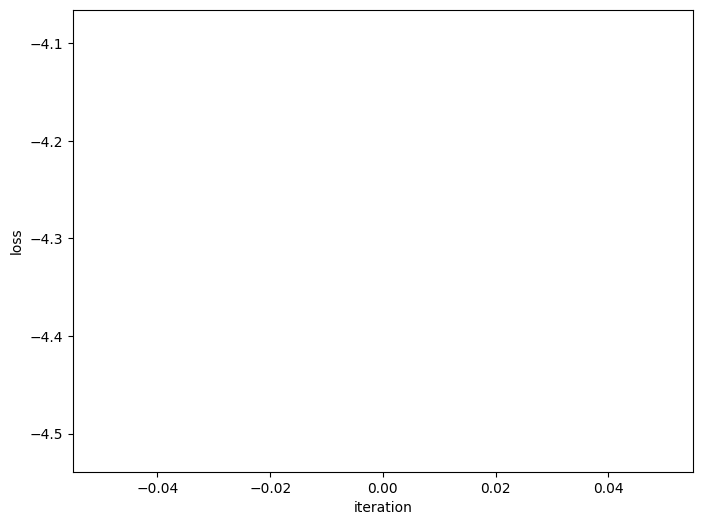

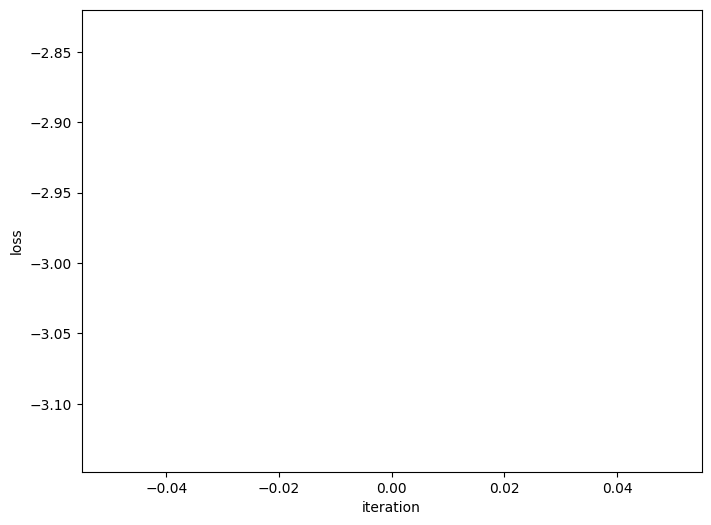

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -586.17020  validloss -573.41156±0.00000  bestvalidloss -573.41156  last_update 0
train: iter 1  trainloss -583.66018  validloss -247.34414±0.00000  bestvalidloss -573.41156  last_update 1
train: iter 2  trainloss -626.98096  validloss -578.32660±0.00000  bestvalidloss -578.32660  last_update 0
train: iter 3  trainloss -617.32826  validloss -574.22042±0.00000  bestvalidloss -578.32660  last_update 1
train: iter 4  trainloss -621.85668  validloss -582.69853±0.00000  bestvalidloss -582.69853  last_update 0
train: iter 5  trainloss -618.35147  validloss -589.78698±0.00000  bestvalidloss -589.78698  last_update 0
train: iter 6  trainloss -618.54498  validloss -600.81737±0.00000  bestvalidloss -600.81737  last_update 0
train: iter 7  trainloss -623.77093  validloss -590.15768±0.00000  bestvalidloss -600.81737  last_update 1
train: iter 8  trainloss -625.18514  validloss -596.51716±0.00000  bestvalidloss -600.81737  last_u

train: iter 76  trainloss -679.10008  validloss -704.69673±0.00000  bestvalidloss -704.69673  last_update 0
train: iter 77  trainloss -710.62422  validloss -622.16424±0.00000  bestvalidloss -704.69673  last_update 1
train: iter 78  trainloss -720.01868  validloss -726.61842±0.00000  bestvalidloss -726.61842  last_update 0
train: iter 79  trainloss -723.59698  validloss -739.74027±0.00000  bestvalidloss -739.74027  last_update 0
train: iter 80  trainloss -716.24095  validloss -693.90200±0.00000  bestvalidloss -739.74027  last_update 1
train: iter 81  trainloss -707.13162  validloss -713.83517±0.00000  bestvalidloss -739.74027  last_update 2
train: iter 82  trainloss -712.55160  validloss -718.17043±0.00000  bestvalidloss -739.74027  last_update 3
train: iter 83  trainloss -720.79046  validloss -715.81408±0.00000  bestvalidloss -739.74027  last_update 4
train: iter 84  trainloss -710.81475  validloss -721.98866±0.00000  bestvalidloss -739.74027  last_update 5
train: iter 85  trainloss -7

train: iter 152  trainloss -754.16802  validloss -758.19560±0.00000  bestvalidloss -797.68477  last_update 1
train: iter 153  trainloss -750.95637  validloss -767.66817±0.00000  bestvalidloss -797.68477  last_update 2
train: iter 154  trainloss -758.70360  validloss -741.50887±0.00000  bestvalidloss -797.68477  last_update 3
train: iter 155  trainloss -772.84194  validloss -791.88838±0.00000  bestvalidloss -797.68477  last_update 4
train: iter 156  trainloss -757.07222  validloss -769.38318±0.00000  bestvalidloss -797.68477  last_update 5
train: iter 157  trainloss -756.26241  validloss -779.51105±0.00000  bestvalidloss -797.68477  last_update 6
train: iter 158  trainloss -757.40474  validloss -751.76050±0.00000  bestvalidloss -797.68477  last_update 7
train: iter 159  trainloss -763.51445  validloss -755.61955±0.00000  bestvalidloss -797.68477  last_update 8
train: iter 160  trainloss -763.88189  validloss -748.87640±0.00000  bestvalidloss -797.68477  last_update 9
train: iter 161  tr

train: iter 228  trainloss -817.91105  validloss -868.19346±0.00000  bestvalidloss -868.19346  last_update 0
train: iter 229  trainloss -818.22052  validloss -858.25308±0.00000  bestvalidloss -868.19346  last_update 1
train: iter 230  trainloss -815.35369  validloss -860.64915±0.00000  bestvalidloss -868.19346  last_update 2
train: iter 231  trainloss -815.11337  validloss -855.26513±0.00000  bestvalidloss -868.19346  last_update 3
train: iter 232  trainloss -811.01694  validloss -865.57690±0.00000  bestvalidloss -868.19346  last_update 4
train: iter 233  trainloss -815.77024  validloss -843.93714±0.00000  bestvalidloss -868.19346  last_update 5
train: iter 234  trainloss -822.36411  validloss -863.81214±0.00000  bestvalidloss -868.19346  last_update 6
train: iter 235  trainloss -817.31695  validloss -822.49329±0.00000  bestvalidloss -868.19346  last_update 7
train: iter 236  trainloss -816.38787  validloss -811.11370±0.00000  bestvalidloss -868.19346  last_update 8
train: iter 237  tr

train: iter 303  trainloss -832.91468  validloss -894.74294±0.00000  bestvalidloss -916.71527  last_update 5
train: iter 304  trainloss -825.77456  validloss -738.94648±0.00000  bestvalidloss -916.71527  last_update 6
train: iter 305  trainloss -851.07163  validloss -890.91542±0.00000  bestvalidloss -916.71527  last_update 7
train: iter 306  trainloss -843.87185  validloss -868.04808±0.00000  bestvalidloss -916.71527  last_update 8
train: iter 307  trainloss -851.63354  validloss -873.64054±0.00000  bestvalidloss -916.71527  last_update 9
train: iter 308  trainloss -856.14163  validloss -892.40341±0.00000  bestvalidloss -916.71527  last_update 10
train: iter 309  trainloss -847.64325  validloss -898.41677±0.00000  bestvalidloss -916.71527  last_update 11
train: iter 310  trainloss -850.57433  validloss -881.86537±0.00000  bestvalidloss -916.71527  last_update 12
train: iter 311  trainloss -854.66729  validloss -904.72045±0.00000  bestvalidloss -916.71527  last_update 13
train: iter 312

train: iter 378  trainloss -870.49476  validloss -931.57423±0.00000  bestvalidloss -954.95948  last_update 6
train: iter 379  trainloss -870.43117  validloss -882.44281±0.00000  bestvalidloss -954.95948  last_update 7
train: iter 380  trainloss -881.16927  validloss -934.39485±0.00000  bestvalidloss -954.95948  last_update 8
train: iter 381  trainloss -875.77569  validloss -863.14786±0.00000  bestvalidloss -954.95948  last_update 9
train: iter 382  trainloss -868.26849  validloss -886.16970±0.00000  bestvalidloss -954.95948  last_update 10
train: iter 383  trainloss -876.39083  validloss -750.35109±0.00000  bestvalidloss -954.95948  last_update 11
train: iter 384  trainloss -880.40638  validloss -935.22272±0.00000  bestvalidloss -954.95948  last_update 12
train: iter 385  trainloss -886.28492  validloss -952.20706±0.00000  bestvalidloss -954.95948  last_update 13
train: iter 386  trainloss -880.76933  validloss -912.05229±0.00000  bestvalidloss -954.95948  last_update 14
train: iter 38

train: iter 453  trainloss -885.82450  validloss -965.86005±0.00000  bestvalidloss -1004.33139  last_update 19
train: iter 454  trainloss -903.33124  validloss -968.94914±0.00000  bestvalidloss -1004.33139  last_update 20
train: iter 455  trainloss -912.59265  validloss -962.55931±0.00000  bestvalidloss -1004.33139  last_update 21
train: iter 456  trainloss -908.41373  validloss -959.74254±0.00000  bestvalidloss -1004.33139  last_update 22
train: iter 457  trainloss -916.81346  validloss -915.30346±0.00000  bestvalidloss -1004.33139  last_update 23
train: iter 458  trainloss -917.67089  validloss -923.21859±0.00000  bestvalidloss -1004.33139  last_update 24
train: iter 459  trainloss -888.74239  validloss -990.02766±0.00000  bestvalidloss -1004.33139  last_update 25
train: iter 460  trainloss -902.82182  validloss -984.48568±0.00000  bestvalidloss -1004.33139  last_update 26
train: iter 461  trainloss -913.17866  validloss -942.47435±0.00000  bestvalidloss -1004.33139  last_update 27
t

train: iter 527  trainloss -928.97390  validloss -932.01396±0.00000  bestvalidloss -1021.86799  last_update 30
train: iter 528  trainloss -919.27512  validloss -970.56313±0.00000  bestvalidloss -1021.86799  last_update 31
train: iter 529  trainloss -925.86271  validloss -975.94631±0.00000  bestvalidloss -1021.86799  last_update 32
train: iter 530  trainloss -952.24825  validloss -1003.61032±0.00000  bestvalidloss -1021.86799  last_update 33
train: iter 531  trainloss -927.40137  validloss -951.13875±0.00000  bestvalidloss -1021.86799  last_update 34
train: iter 532  trainloss -925.24936  validloss -980.09908±0.00000  bestvalidloss -1021.86799  last_update 35
train: iter 533  trainloss -908.89411  validloss -1010.25126±0.00000  bestvalidloss -1021.86799  last_update 36
train: iter 534  trainloss -937.17882  validloss -948.73974±0.00000  bestvalidloss -1021.86799  last_update 37
train: iter 535  trainloss -923.55222  validloss -948.51005±0.00000  bestvalidloss -1021.86799  last_update 38

train: iter 601  trainloss -953.88129  validloss -1018.87457±0.00000  bestvalidloss -1045.83976  last_update 11
train: iter 602  trainloss -956.37176  validloss -1033.80449±0.00000  bestvalidloss -1045.83976  last_update 12
train: iter 603  trainloss -960.53789  validloss -976.10458±0.00000  bestvalidloss -1045.83976  last_update 13
train: iter 604  trainloss -952.51079  validloss -987.88006±0.00000  bestvalidloss -1045.83976  last_update 14
train: iter 605  trainloss -938.54667  validloss -1012.30885±0.00000  bestvalidloss -1045.83976  last_update 15
train: iter 606  trainloss -936.06003  validloss -985.67385±0.00000  bestvalidloss -1045.83976  last_update 16
train: iter 607  trainloss -956.34046  validloss -994.87712±0.00000  bestvalidloss -1045.83976  last_update 17
train: iter 608  trainloss -966.31815  validloss -1036.35589±0.00000  bestvalidloss -1045.83976  last_update 18
train: iter 609  trainloss -955.40185  validloss -974.48399±0.00000  bestvalidloss -1045.83976  last_update 

train: iter 675  trainloss -964.18011  validloss -1029.23150±0.00000  bestvalidloss -1054.39470  last_update 45
train: iter 676  trainloss -960.16960  validloss -1033.71271±0.00000  bestvalidloss -1054.39470  last_update 46
train: iter 677  trainloss -957.67385  validloss -1002.24214±0.00000  bestvalidloss -1054.39470  last_update 47
train: iter 678  trainloss -966.91021  validloss -1025.85383±0.00000  bestvalidloss -1054.39470  last_update 48
train: iter 679  trainloss -973.86950  validloss -1045.26491±0.00000  bestvalidloss -1054.39470  last_update 49
train: iter 680  trainloss -958.87297  validloss -964.51405±0.00000  bestvalidloss -1054.39470  last_update 50
train: iter 681  trainloss -980.32140  validloss -996.90123±0.00000  bestvalidloss -1054.39470  last_update 51
train: iter 682  trainloss -972.00329  validloss -974.19026±0.00000  bestvalidloss -1054.39470  last_update 52
train: iter 683  trainloss -953.14269  validloss -942.82687±0.00000  bestvalidloss -1054.39470  last_update

train: iter 749  trainloss -971.92130  validloss -141.95493±0.00000  bestvalidloss -1078.06790  last_update 8
train: iter 750  trainloss -999.09700  validloss -1055.21313±0.00000  bestvalidloss -1078.06790  last_update 9
train: iter 751  trainloss -986.87665  validloss -1009.94301±0.00000  bestvalidloss -1078.06790  last_update 10
train: iter 752  trainloss -907.65042  validloss -904.01698±0.00000  bestvalidloss -1078.06790  last_update 11
train: iter 753  trainloss -977.38085  validloss 481.66790±0.00000  bestvalidloss -1078.06790  last_update 12
train: iter 754  trainloss -978.22665  validloss -596.21622±0.00000  bestvalidloss -1078.06790  last_update 13
train: iter 755  trainloss -979.01713  validloss -1021.27953±0.00000  bestvalidloss -1078.06790  last_update 14
train: iter 756  trainloss -992.14388  validloss -1009.41108±0.00000  bestvalidloss -1078.06790  last_update 15
train: iter 757  trainloss -951.11374  validloss -1080.14615±0.00000  bestvalidloss -1080.14615  last_update 0


train: iter 823  trainloss -1022.26920  validloss -1012.81691±0.00000  bestvalidloss -1090.00863  last_update 40
train: iter 824  trainloss -1011.40723  validloss -894.72138±0.00000  bestvalidloss -1090.00863  last_update 41
train: iter 825  trainloss -1016.47283  validloss -1062.08868±0.00000  bestvalidloss -1090.00863  last_update 42
train: iter 826  trainloss -1018.43347  validloss -871.58740±0.00000  bestvalidloss -1090.00863  last_update 43
train: iter 827  trainloss -1014.94786  validloss -973.91341±0.00000  bestvalidloss -1090.00863  last_update 44
train: iter 828  trainloss -1011.22176  validloss -1041.67251±0.00000  bestvalidloss -1090.00863  last_update 45
train: iter 829  trainloss -963.73567  validloss -1024.73353±0.00000  bestvalidloss -1090.00863  last_update 46
train: iter 830  trainloss -1010.01152  validloss -996.33752±0.00000  bestvalidloss -1090.00863  last_update 47
train: iter 831  trainloss -1034.68866  validloss -785.65897±0.00000  bestvalidloss -1090.00863  last

train: iter 897  trainloss -1028.31924  validloss 2158.17925±0.00000  bestvalidloss -1116.62242  last_update 47
train: iter 898  trainloss -1031.83458  validloss 1876.76146±0.00000  bestvalidloss -1116.62242  last_update 48
train: iter 899  trainloss -967.32043  validloss 2104.34725±0.00000  bestvalidloss -1116.62242  last_update 49
train: iter 900  trainloss -1037.28536  validloss 66.17963±0.00000  bestvalidloss -1116.62242  last_update 50
train: iter 901  trainloss -1018.75505  validloss 1637.68362±0.00000  bestvalidloss -1116.62242  last_update 51
train: iter 902  trainloss -1038.25226  validloss 2513.25408±0.00000  bestvalidloss -1116.62242  last_update 52
train: iter 903  trainloss -990.72164  validloss 2838.58337±0.00000  bestvalidloss -1116.62242  last_update 53
train: iter 904  trainloss -1015.69625  validloss 3625.20240±0.00000  bestvalidloss -1116.62242  last_update 54
train: iter 905  trainloss -1013.04881  validloss 3195.81215±0.00000  bestvalidloss -1116.62242  last_update

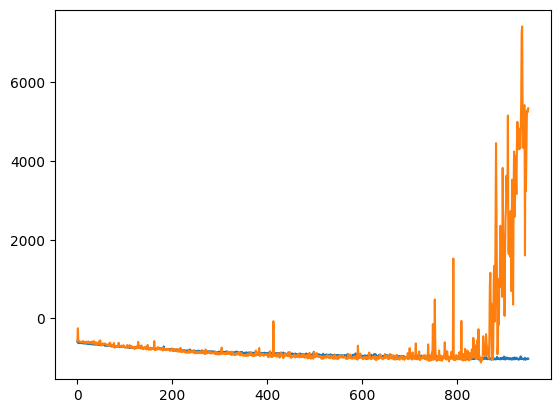

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-16 08:33:40.094680


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [ 49.1166814   39.99883444 -75.8427202  -25.23622357] [ 0.3364992  31.89766489 -1.72541092  0.33183782] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 190
predict diverge [ 17.80601423  23.60432928 -36.88743739 -30.87599154] [ 1.09110637  0.95782701 -1.60573886 -0.60107535] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 37
predict diverge [79.87980166 23.45143681  3.54276589  7.50384948] [1.06280917 0.08968172 0.35991544 1.28115472] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 139

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.83529  validloss 4.30422±0.00000  bestvalidloss 4.30422  last_update 0
train: iter 1  trainloss 0.93122  validloss 1.58916±0.00000  bestvalidloss 1.58916  last_update 0
train: iter 2  trainloss 0.80158  validloss 1.32612±0.00000  bestvalidloss 1.32612  last_update 0
train: iter 3  trainloss 0.75058  validloss 1.22789±0.00000  bestvalidloss 1.22789  last_update 0
train: iter 4  trainloss 0.70844  validloss 1.14840±0.00000  bestvalidloss 1.14840  last_update 0
train: iter 5  trainloss 0.67847  validloss 1.12768±0.00000  bestvalidloss 1.12768  last_update 0
train: iter 6  trainloss 0.65070  validloss 1.05565±0.00000  bestvalidloss 1.05565  last_update 0
train: iter 7  trainloss 0.63439  validloss 1.06988±0.00000  bestvalidloss 1.05565  last_update 1
train: iter 8  trainloss 0.62429  validloss 1.00205±0.00000  bestvalidloss 1.00205  last_update 0
train: iter 9  trainloss 0.60749  validloss 1.00597±0.00000  bestvalidloss 1.00205  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.47054  validloss 1.03071±0.00000  bestvalidloss 0.92765  last_update 67
train: iter 84  trainloss 0.47821  validloss 1.05833±0.00000  bestvalidloss 0.92765  last_update 68
train: iter 85  trainloss 0.46927  validloss 1.10691±0.00000  bestvalidloss 0.92765  last_update 69
train: iter 86  trainloss 0.48394  validloss 1.03413±0.00000  bestvalidloss 0.92765  last_update 70
train: iter 87  trainloss 0.47081  validloss 1.05440±0.00000  bestvalidloss 0.92765  last_update 71
train: iter 88  trainloss 0.47580  validloss 1.11027±0.00000  bestvalidloss 0.92765  last_update 72
train: iter 89  trainloss 0.47026  validloss 1.04488±0.00000  bestvalidloss 0.92765  last_update 73
train: iter 90  trainloss 0.46547  validloss 1.06163±0.00000  bestvalidloss 0.92765  last_update 74
train: iter 91  trainloss 0.47009  validloss 1.05936±0.00000  bestvalidloss 0.92765  last_update 75
train: iter 92  trainloss 0.47309  validloss 1.04422±0.00000  bestvalidloss 0.92765  last_update 76


train_loss:  -4.715884954664111
valid_loss:  21.57254187284708
weight_alpha 1.0 h_min_tilde -11.593983 ell_tilde 0.5418004108381268 kappa_tilde 0.0001435278242186328
train_loss:  -3.390603997659684
valid_loss:  20.578838149356837
weight_alpha 0.2 h_min_tilde -11.593983 ell_tilde 1.4032844317436206 kappa_tilde 0.00013868962755180973


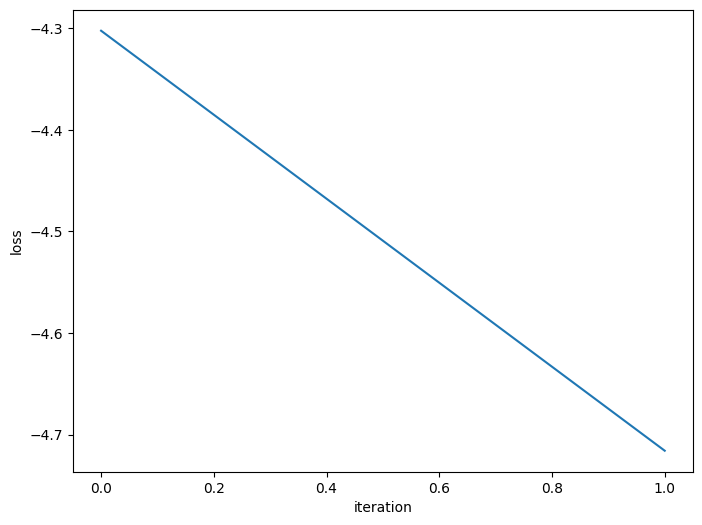

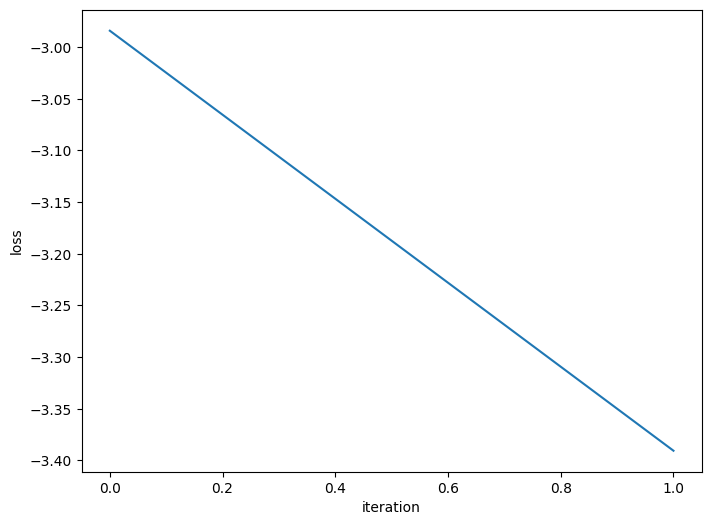

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -687.62750  validloss 4163.41796±0.00000  bestvalidloss 4163.41796  last_update 0
train: iter 1  trainloss -701.57709  validloss 6622.11797±0.00000  bestvalidloss 4163.41796  last_update 1
train: iter 2  trainloss -681.61111  validloss 7965.96290±0.00000  bestvalidloss 4163.41796  last_update 2
train: iter 3  trainloss -700.04968  validloss 7054.82950±0.00000  bestvalidloss 4163.41796  last_update 3
train: iter 4  trainloss -676.01491  validloss 3679.82360±0.00000  bestvalidloss 3679.82360  last_update 0
train: iter 5  trainloss -699.20339  validloss 3796.41530±0.00000  bestvalidloss 3679.82360  last_update 1
train: iter 6  trainloss -687.67537  validloss 3917.40310±0.00000  bestvalidloss 3679.82360  last_update 2
train: iter 7  trainloss -684.92726  validloss 4283.12132±0.00000  bestvalidloss 3679.82360  last_update 3
train: iter 8  trainloss -697.60198  validloss 3843.57950±0.00000  bestvalidloss 3679.82360  last_u

train: iter 76  trainloss -717.18864  validloss 5226.96100±0.00000  bestvalidloss 2049.62590  last_update 19
train: iter 77  trainloss -707.76840  validloss 4372.42147±0.00000  bestvalidloss 2049.62590  last_update 20
train: iter 78  trainloss -713.01717  validloss 5944.43203±0.00000  bestvalidloss 2049.62590  last_update 21
train: iter 79  trainloss -708.45269  validloss 5471.70560±0.00000  bestvalidloss 2049.62590  last_update 22
train: iter 80  trainloss -712.81075  validloss 6058.90971±0.00000  bestvalidloss 2049.62590  last_update 23
train: iter 81  trainloss -721.80580  validloss 4642.45423±0.00000  bestvalidloss 2049.62590  last_update 24
train: iter 82  trainloss -688.79650  validloss 4536.65113±0.00000  bestvalidloss 2049.62590  last_update 25
train: iter 83  trainloss -718.85603  validloss 5606.74367±0.00000  bestvalidloss 2049.62590  last_update 26
train: iter 84  trainloss -703.56578  validloss 6069.91660±0.00000  bestvalidloss 2049.62590  last_update 27
train: iter 85  tra

train: iter 151  trainloss -716.03586  validloss 3331.00394±0.00000  bestvalidloss 1558.47370  last_update 4
train: iter 152  trainloss -734.93358  validloss 2829.32438±0.00000  bestvalidloss 1558.47370  last_update 5
train: iter 153  trainloss -721.85333  validloss 3554.73260±0.00000  bestvalidloss 1558.47370  last_update 6
train: iter 154  trainloss -739.07181  validloss 4099.28954±0.00000  bestvalidloss 1558.47370  last_update 7
train: iter 155  trainloss -740.38044  validloss 5073.30996±0.00000  bestvalidloss 1558.47370  last_update 8
train: iter 156  trainloss -747.61082  validloss 6369.10900±0.00000  bestvalidloss 1558.47370  last_update 9
train: iter 157  trainloss -735.35077  validloss 6598.37384±0.00000  bestvalidloss 1558.47370  last_update 10
train: iter 158  trainloss -737.25675  validloss 5000.75352±0.00000  bestvalidloss 1558.47370  last_update 11
train: iter 159  trainloss -742.59173  validloss 4694.41113±0.00000  bestvalidloss 1558.47370  last_update 12
train: iter 160 

train: iter 226  trainloss -761.81473  validloss 4567.05506±0.00000  bestvalidloss 1558.47370  last_update 79
train: iter 227  trainloss -743.16175  validloss 3935.43813±0.00000  bestvalidloss 1558.47370  last_update 80
train: iter 228  trainloss -484.20124  validloss 4223.18721±0.00000  bestvalidloss 1558.47370  last_update 81
train: iter 229  trainloss -682.01028  validloss -27.65865±0.00000  bestvalidloss -27.65865  last_update 0
train: iter 230  trainloss -743.99522  validloss 1484.82346±0.00000  bestvalidloss -27.65865  last_update 1
train: iter 231  trainloss -744.28998  validloss 5135.97026±0.00000  bestvalidloss -27.65865  last_update 2
train: iter 232  trainloss -745.31877  validloss 4451.22181±0.00000  bestvalidloss -27.65865  last_update 3
train: iter 233  trainloss -764.92632  validloss 2787.75444±0.00000  bestvalidloss -27.65865  last_update 4
train: iter 234  trainloss -763.82456  validloss 3402.12481±0.00000  bestvalidloss -27.65865  last_update 5
train: iter 235  trainl

train: iter 302  trainloss -776.46747  validloss 4394.26790±0.00000  bestvalidloss -430.34905  last_update 29
train: iter 303  trainloss -764.11527  validloss 1532.13876±0.00000  bestvalidloss -430.34905  last_update 30
train: iter 304  trainloss -781.34530  validloss 2678.35580±0.00000  bestvalidloss -430.34905  last_update 31
train: iter 305  trainloss -780.54744  validloss 1644.68006±0.00000  bestvalidloss -430.34905  last_update 32
train: iter 306  trainloss -756.13783  validloss 3877.22694±0.00000  bestvalidloss -430.34905  last_update 33
train: iter 307  trainloss -741.53597  validloss 3808.02014±0.00000  bestvalidloss -430.34905  last_update 34
train: iter 308  trainloss -758.84916  validloss 4955.38052±0.00000  bestvalidloss -430.34905  last_update 35
train: iter 309  trainloss -767.72720  validloss 3431.12836±0.00000  bestvalidloss -430.34905  last_update 36
train: iter 310  trainloss -785.78387  validloss 4184.11004±0.00000  bestvalidloss -430.34905  last_update 37
train: ite

train: iter 377  trainloss -776.35462  validloss 1373.82331±0.00000  bestvalidloss -528.85082  last_update 36
train: iter 378  trainloss -780.65491  validloss -280.95675±0.00000  bestvalidloss -528.85082  last_update 37
train: iter 379  trainloss -803.46905  validloss 3887.14388±0.00000  bestvalidloss -528.85082  last_update 38
train: iter 380  trainloss -755.09701  validloss 2060.15511±0.00000  bestvalidloss -528.85082  last_update 39
train: iter 381  trainloss -800.91837  validloss 1753.98422±0.00000  bestvalidloss -528.85082  last_update 40
train: iter 382  trainloss -804.57353  validloss 4584.97468±0.00000  bestvalidloss -528.85082  last_update 41
train: iter 383  trainloss -796.40671  validloss 4496.80935±0.00000  bestvalidloss -528.85082  last_update 42
train: iter 384  trainloss -805.83974  validloss 3007.34380±0.00000  bestvalidloss -528.85082  last_update 43
train: iter 385  trainloss -807.06384  validloss 1359.90036±0.00000  bestvalidloss -528.85082  last_update 44
train: ite

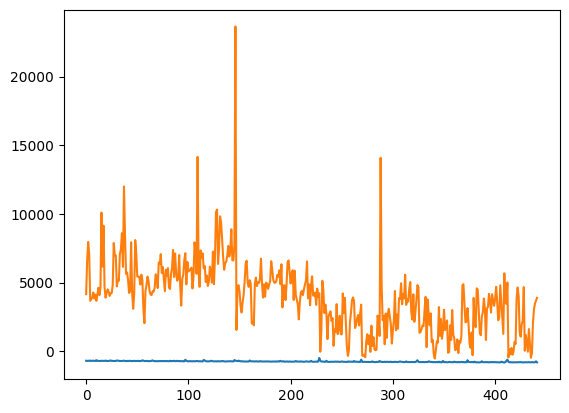

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-16 08:59:39.447900


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [ 11.11372249  24.17222859 -30.33546904 -28.82280056] [ 0.71764867  6.34419591 -1.39834869 -1.35072709] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 72
predict diverge [ 12.17045217  24.54810995 -22.90247326 -26.57826728] [ 1.01739353  2.02521186 -1.32276436 -0.89119773] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 44
predict diverge [ 11.04410478  24.00577179 -29.88233541 -28.04431461] [ 0.86552531  4.65563373 -1.38009272 -0.40580061] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 43
predict diverge [-69.35588979  23.56677659 -65.14676175 -30.63540508] [-0.80125808 15.94221589 -1.57008549 -2.85301025] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 79
predict diverge [ 15.19744022  23.912112   -23.36712167 -27.0836572 ] [ 1.01016692  1.00710431 -1.36

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57749  validloss 0.85344±0.00000  bestvalidloss 0.85344  last_update 0
train: iter 1  trainloss 0.54254  validloss 0.75966±0.00000  bestvalidloss 0.75966  last_update 0
train: iter 2  trainloss 0.54210  validloss 0.72234±0.00000  bestvalidloss 0.72234  last_update 0
train: iter 3  trainloss 0.53362  validloss 0.73340±0.00000  bestvalidloss 0.72234  last_update 1
train: iter 4  trainloss 0.51844  validloss 0.72490±0.00000  bestvalidloss 0.72234  last_update 2
train: iter 5  trainloss 0.51978  validloss 0.70517±0.00000  bestvalidloss 0.70517  last_update 0
train: iter 6  trainloss 0.52565  validloss 0.71733±0.00000  bestvalidloss 0.70517  last_update 1
train: iter 7  trainloss 0.51827  validloss 0.71780±0.00000  bestvalidloss 0.70517  last_update 2
train: iter 8  trainloss 0.50696  validloss 0.73389±0.00000  bestvalidloss 0.70517  last_update 3
train: iter 9  trainloss 0.51629  validloss 0.74367±0.00000  bestvalidloss 0.70517  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.47105  validloss 0.79766±0.00000  bestvalidloss 0.69506  last_update 57
train: iter 84  trainloss 0.46433  validloss 0.74285±0.00000  bestvalidloss 0.69506  last_update 58
train: iter 85  trainloss 0.46553  validloss 0.77756±0.00000  bestvalidloss 0.69506  last_update 59
train: iter 86  trainloss 0.46064  validloss 0.72935±0.00000  bestvalidloss 0.69506  last_update 60
train: iter 87  trainloss 0.47049  validloss 0.74672±0.00000  bestvalidloss 0.69506  last_update 61
train: iter 88  trainloss 0.46554  validloss 0.73326±0.00000  bestvalidloss 0.69506  last_update 62
train: iter 89  trainloss 0.46674  validloss 0.74379±0.00000  bestvalidloss 0.69506  last_update 63
train: iter 90  trainloss 0.45638  validloss 0.74847±0.00000  bestvalidloss 0.69506  last_update 64
train: iter 91  trainloss 0.46282  validloss 0.75791±0.00000  bestvalidloss 0.69506  last_update 65
train: iter 92  trainloss 0.45956  validloss 0.74736±0.00000  bestvalidloss 0.69506  last_update 66


train_loss:  -5.990335024353861
valid_loss:  -1.3281976203918455
weight_alpha 1.0 h_min_tilde -11.50054 ell_tilde -5.057907543561458 kappa_tilde 0.00019698734812526915
train_loss:  -3.772959479618072
valid_loss:  10.19290519964695
weight_alpha 0.2 h_min_tilde -11.50054 ell_tilde -0.9797865437650677 kappa_tilde 0.00015415108545591415


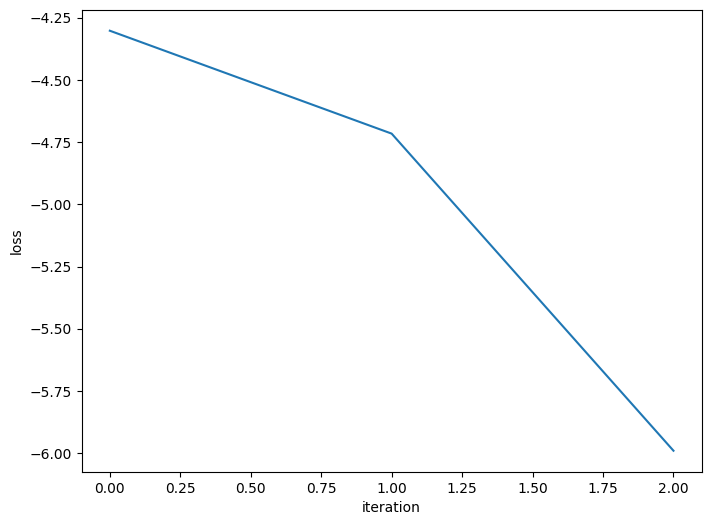

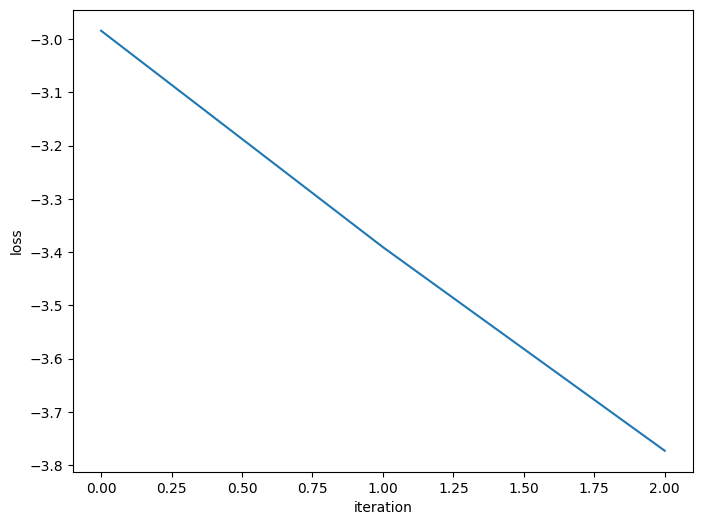

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -744.01331  validloss 2077.82821±0.00000  bestvalidloss 2077.82821  last_update 0
train: iter 1  trainloss -756.42711  validloss 393.69687±0.00000  bestvalidloss 393.69687  last_update 0
train: iter 2  trainloss -729.63755  validloss 1720.92717±0.00000  bestvalidloss 393.69687  last_update 1
train: iter 3  trainloss -746.54471  validloss 3701.60840±0.00000  bestvalidloss 393.69687  last_update 2
train: iter 4  trainloss -763.55827  validloss 2409.88717±0.00000  bestvalidloss 393.69687  last_update 3
train: iter 5  trainloss -757.46898  validloss 2311.08290±0.00000  bestvalidloss 393.69687  last_update 4
train: iter 6  trainloss -761.41211  validloss 2555.81340±0.00000  bestvalidloss 393.69687  last_update 5
train: iter 7  trainloss -756.42733  validloss 1994.82059±0.00000  bestvalidloss 393.69687  last_update 6
train: iter 8  trainloss -752.11612  validloss 1770.57885±0.00000  bestvalidloss 393.69687  last_update 7
t

train: iter 76  trainloss -770.50599  validloss 1485.87417±0.00000  bestvalidloss -620.85984  last_update 45
train: iter 77  trainloss -768.25006  validloss 530.39246±0.00000  bestvalidloss -620.85984  last_update 46
train: iter 78  trainloss -740.50724  validloss 16.22342±0.00000  bestvalidloss -620.85984  last_update 47
train: iter 79  trainloss -769.13851  validloss 298.81197±0.00000  bestvalidloss -620.85984  last_update 48
train: iter 80  trainloss -772.30730  validloss 692.90343±0.00000  bestvalidloss -620.85984  last_update 49
train: iter 81  trainloss -775.71577  validloss 794.15537±0.00000  bestvalidloss -620.85984  last_update 50
train: iter 82  trainloss -766.41351  validloss 274.15147±0.00000  bestvalidloss -620.85984  last_update 51
train: iter 83  trainloss -776.42474  validloss 1501.76527±0.00000  bestvalidloss -620.85984  last_update 52
train: iter 84  trainloss -769.93509  validloss 547.01816±0.00000  bestvalidloss -620.85984  last_update 53
train: iter 85  trainloss -

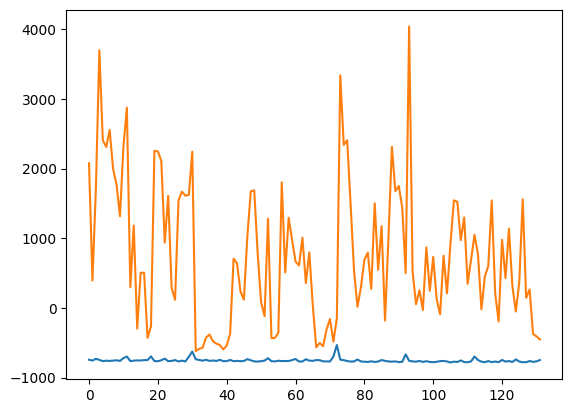

alpha 0.2 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-16 09:25:35.250440


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.50425  validloss 0.56153±0.00000  bestvalidloss 0.56153  last_update 0
train: iter 1  trainloss 0.49471  validloss 0.54839±0.00000  bestvalidloss 0.54839  last_update 0
train: iter 2  trainloss 0.48425  validloss 0.56941±0.00000  bestvalidloss 0.54839  last_update 1
train: iter 3  trainloss 0.48264  validloss 0.53747±0.00000  bestvalidloss 0.53747  last_update 0
train: iter 4  trainloss 0.48079  validloss 0.55570±0.00000  bestvalidloss 0.53747  last_update 1
train: iter 5  trainloss 0.48118  validloss 0.53902±0.00000  bestvalidloss 0.53747  last_update 2
train: iter 6  trainloss 0.47811  validloss 0.55963±0.00000  bestvalidloss 0.53747  last_update 3
train: iter 7  trainloss 0.47799  validloss 0.55505±0.00000  bestvalidloss 0.53747  last_update 4
train: iter 8  trainloss 0.47742  validloss 0.52748±0.00000  bestvalidloss 0.52748  last_update 0
train: iter 9  trainloss 0.47326  validloss 0.53366±0.00000  bestvalidloss 0.52748  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.44132  validloss 0.51369±0.00000  bestvalidloss 0.50057  last_update 36
train: iter 84  trainloss 0.43973  validloss 0.52562±0.00000  bestvalidloss 0.50057  last_update 37
train: iter 85  trainloss 0.44106  validloss 0.56573±0.00000  bestvalidloss 0.50057  last_update 38
train: iter 86  trainloss 0.43751  validloss 0.50902±0.00000  bestvalidloss 0.50057  last_update 39
train: iter 87  trainloss 0.43695  validloss 0.52281±0.00000  bestvalidloss 0.50057  last_update 40
train: iter 88  trainloss 0.44071  validloss 0.54289±0.00000  bestvalidloss 0.50057  last_update 41
train: iter 89  trainloss 0.43887  validloss 0.52828±0.00000  bestvalidloss 0.50057  last_update 42
train: iter 90  trainloss 0.43926  validloss 0.52514±0.00000  bestvalidloss 0.50057  last_update 43
train: iter 91  trainloss 0.44659  validloss 0.56246±0.00000  bestvalidloss 0.50057  last_update 44
train: iter 92  trainloss 0.43620  validloss 0.52611±0.00000  bestvalidloss 0.50057  last_update 45


train_loss:  -5.594706326249242
valid_loss:  -2.922045894134045
weight_alpha 1.0 h_min_tilde -11.432825 ell_tilde -5.060174239826202 kappa_tilde 0.0001980660050573012
train_loss:  -3.6813451350212096
valid_loss:  -0.7849751331329347
weight_alpha 0.2 h_min_tilde -11.432825 ell_tilde -3.1020711346435546 kappa_tilde 0.0001732318926791051


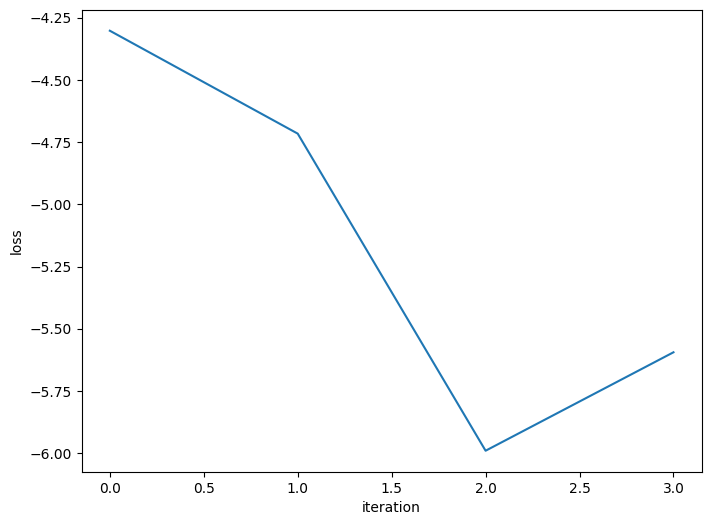

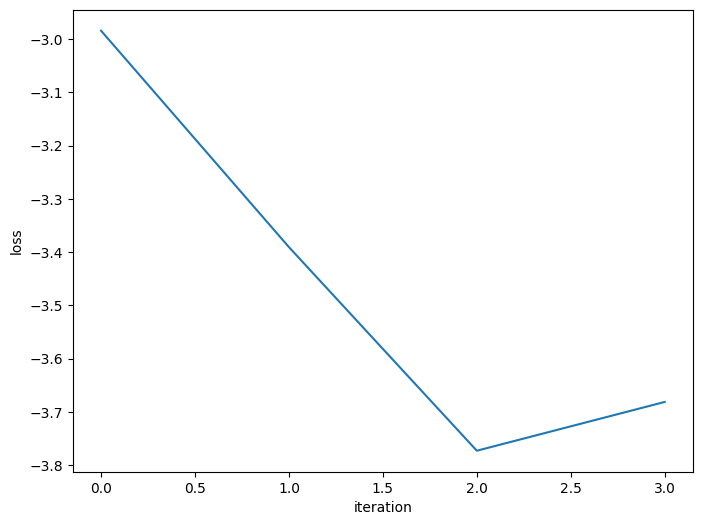

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -770.48274  validloss -203.13681±0.00000  bestvalidloss -203.13681  last_update 0
train: iter 1  trainloss -762.82688  validloss -147.62841±0.00000  bestvalidloss -203.13681  last_update 1
train: iter 2  trainloss -779.41268  validloss 1760.55977±0.00000  bestvalidloss -203.13681  last_update 2
train: iter 3  trainloss -773.94128  validloss 1279.53827±0.00000  bestvalidloss -203.13681  last_update 3
train: iter 4  trainloss -770.22260  validloss 1037.99145±0.00000  bestvalidloss -203.13681  last_update 4
train: iter 5  trainloss -787.07967  validloss 440.70645±0.00000  bestvalidloss -203.13681  last_update 5
train: iter 6  trainloss -765.72113  validloss 298.59692±0.00000  bestvalidloss -203.13681  last_update 6
train: iter 7  trainloss -760.64286  validloss 847.35522±0.00000  bestvalidloss -203.13681  last_update 7
train: iter 8  trainloss -779.86560  validloss -163.60254±0.00000  bestvalidloss -203.13681  last_upda

train: iter 76  trainloss -789.99674  validloss -601.52391±0.00000  bestvalidloss -664.09751  last_update 12
train: iter 77  trainloss -791.64518  validloss -618.24891±0.00000  bestvalidloss -664.09751  last_update 13
train: iter 78  trainloss -793.47065  validloss -618.22388±0.00000  bestvalidloss -664.09751  last_update 14
train: iter 79  trainloss -787.80915  validloss -627.67715±0.00000  bestvalidloss -664.09751  last_update 15
train: iter 80  trainloss -789.35271  validloss -613.79417±0.00000  bestvalidloss -664.09751  last_update 16
train: iter 81  trainloss -790.00405  validloss -606.43379±0.00000  bestvalidloss -664.09751  last_update 17
train: iter 82  trainloss -788.67010  validloss -636.69733±0.00000  bestvalidloss -664.09751  last_update 18
train: iter 83  trainloss -792.26721  validloss -628.19168±0.00000  bestvalidloss -664.09751  last_update 19
train: iter 84  trainloss -767.86888  validloss -597.31851±0.00000  bestvalidloss -664.09751  last_update 20
train: iter 85  tra

train: iter 151  trainloss -805.11953  validloss -639.37024±0.00000  bestvalidloss -668.35088  last_update 11
train: iter 152  trainloss -803.90246  validloss -657.70030±0.00000  bestvalidloss -668.35088  last_update 12
train: iter 153  trainloss -741.60404  validloss -650.39494±0.00000  bestvalidloss -668.35088  last_update 13
train: iter 154  trainloss -783.28583  validloss -644.95774±0.00000  bestvalidloss -668.35088  last_update 14
train: iter 155  trainloss -799.66662  validloss -641.13025±0.00000  bestvalidloss -668.35088  last_update 15
train: iter 156  trainloss -805.17513  validloss -637.81249±0.00000  bestvalidloss -668.35088  last_update 16
train: iter 157  trainloss -795.58552  validloss -653.28591±0.00000  bestvalidloss -668.35088  last_update 17
train: iter 158  trainloss -799.02796  validloss -638.47667±0.00000  bestvalidloss -668.35088  last_update 18
train: iter 159  trainloss -797.31679  validloss -629.08793±0.00000  bestvalidloss -668.35088  last_update 19
train: ite

train: iter 226  trainloss -792.99904  validloss -687.47580±0.00000  bestvalidloss -695.80832  last_update 18
train: iter 227  trainloss -796.94708  validloss -609.03898±0.00000  bestvalidloss -695.80832  last_update 19
train: iter 228  trainloss -804.61330  validloss -653.51176±0.00000  bestvalidloss -695.80832  last_update 20
train: iter 229  trainloss -815.66013  validloss -673.11994±0.00000  bestvalidloss -695.80832  last_update 21
train: iter 230  trainloss -813.62935  validloss -656.41318±0.00000  bestvalidloss -695.80832  last_update 22
train: iter 231  trainloss -813.82259  validloss -670.48414±0.00000  bestvalidloss -695.80832  last_update 23
train: iter 232  trainloss -801.81300  validloss -656.67428±0.00000  bestvalidloss -695.80832  last_update 24
train: iter 233  trainloss -818.00088  validloss -650.85572±0.00000  bestvalidloss -695.80832  last_update 25
train: iter 234  trainloss -809.59299  validloss -702.00106±0.00000  bestvalidloss -702.00106  last_update 0
train: iter

train: iter 301  trainloss -814.86570  validloss -642.01676±0.00000  bestvalidloss -702.00106  last_update 67
train: iter 302  trainloss -816.66971  validloss -665.71177±0.00000  bestvalidloss -702.00106  last_update 68
train: iter 303  trainloss -807.37230  validloss -607.32268±0.00000  bestvalidloss -702.00106  last_update 69
train: iter 304  trainloss -783.37533  validloss -670.72834±0.00000  bestvalidloss -702.00106  last_update 70
train: iter 305  trainloss -813.27850  validloss -598.26903±0.00000  bestvalidloss -702.00106  last_update 71
train: iter 306  trainloss -813.54139  validloss -573.64552±0.00000  bestvalidloss -702.00106  last_update 72
train: iter 307  trainloss -792.44953  validloss -597.82471±0.00000  bestvalidloss -702.00106  last_update 73
train: iter 308  trainloss -804.59864  validloss -612.55970±0.00000  bestvalidloss -702.00106  last_update 74
train: iter 309  trainloss -804.25159  validloss -624.64543±0.00000  bestvalidloss -702.00106  last_update 75
train: ite

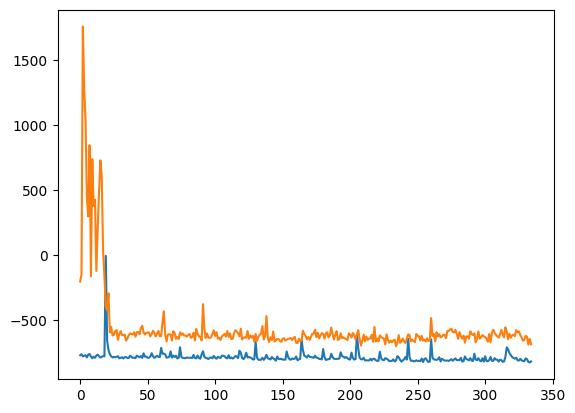

alpha 0.2 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-16 09:52:46.799241


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [ -9.52038589 -24.35302417 -14.99554549  23.45073375] [-1.05801221 -1.15524277  1.23261368  1.42471838] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 195

 2
predict diverge [-18.62001538 -23.55352998  -9.15984653  22.36906442] [-0.99270832 -1.36649314  1.17025161  1.45905132] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 112

 3

 4
predict diverge [-21.69800019 -23.59004057  -3.45544531  23.28565463] [-1.03624309 -1.02209487  1.21703982  0.54642225] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 128
predict diverge [-12.42777379 -24.72257998 -10.67973451  24.96579411] [-1.09154348 -1.38551499  1.25678271  1.52611399] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 149
predict diverge [-15.62229153 -24.31528166  -5.92125539  24.62211644] [-1.048617


 37

 38
predict diverge [-19.84637865 -23.79731804  11.77012633  21.28313999] [-1.04410593 -0.958475    1.15954254  0.56562897] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 174

 39
predict diverge [ -5.77156364 -23.80900193  -8.36445453  23.30290298] [-1.07122426 -1.46710669  1.21132241  1.61020694] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 146
predict diverge [-12.86962692 -24.19208128  -8.96694282  23.3813387 ] [-1.05090074 -1.42774085  1.21972288  1.53031795] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 145

 40
predict diverge [-11.30787112 -23.45920498 -12.33774241  24.11937365] [-1.02570661 -1.25626838  1.25032052  1.42309731] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 175

 41
predict diverge [ -7.8828179  -23.92124564  -6.0673265   23.7362355 ] [-1.0

predict diverge [-13.77023412 -23.82314318  -6.31554495  22.69174698] [-1.08335568 -1.47998694  1.16649936  1.48454142] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 118
predict diverge [-16.76312202 -24.23800076  -3.92341364  23.09842668] [-1.06334362 -1.34922803  1.1722128   1.04796061] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 102

 70
predict diverge [  1.33382043 -24.5517006   -6.40354205  24.82333806] [-1.12346965 -1.57283129  1.25983154  1.77335322] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 175

 71
predict diverge [ -7.03721931 -24.62125095  -9.49945087  25.53512529] [-1.10681367 -1.44610316  1.3318126   1.53540763] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 179

 72
predict diverge [-13.67196221 -23.52739174  -8.26876072  23.98632312] [-1.0455459  -1

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58881  validloss 0.82080±0.00000  bestvalidloss 0.82080  last_update 0
train: iter 1  trainloss 0.52197  validloss 0.71274±0.00000  bestvalidloss 0.71274  last_update 0
train: iter 2  trainloss 0.50825  validloss 0.69509±0.00000  bestvalidloss 0.69509  last_update 0
train: iter 3  trainloss 0.49382  validloss 0.62846±0.00000  bestvalidloss 0.62846  last_update 0
train: iter 4  trainloss 0.48298  validloss 0.62903±0.00000  bestvalidloss 0.62846  last_update 1
train: iter 5  trainloss 0.47964  validloss 0.62062±0.00000  bestvalidloss 0.62062  last_update 0
train: iter 6  trainloss 0.48110  validloss 0.59724±0.00000  bestvalidloss 0.59724  last_update 0
train: iter 7  trainloss 0.47438  validloss 0.59552±0.00000  bestvalidloss 0.59552  last_update 0
train: iter 8  trainloss 0.47457  validloss 0.57783±0.00000  bestvalidloss 0.57783  last_update 0
train: iter 9  trainloss 0.47303  validloss 0.55540±0.00000  bestvalidloss 0.55540  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.43120  validloss 0.56852±0.00000  bestvalidloss 0.53497  last_update 34
train: iter 84  trainloss 0.42874  validloss 0.55219±0.00000  bestvalidloss 0.53497  last_update 35
train: iter 85  trainloss 0.43072  validloss 0.58938±0.00000  bestvalidloss 0.53497  last_update 36
train: iter 86  trainloss 0.43130  validloss 0.58661±0.00000  bestvalidloss 0.53497  last_update 37
train: iter 87  trainloss 0.42871  validloss 0.56237±0.00000  bestvalidloss 0.53497  last_update 38
train: iter 88  trainloss 0.43778  validloss 0.56825±0.00000  bestvalidloss 0.53497  last_update 39
train: iter 89  trainloss 0.42605  validloss 0.55461±0.00000  bestvalidloss 0.53497  last_update 40
train: iter 90  trainloss 0.42962  validloss 0.55073±0.00000  bestvalidloss 0.53497  last_update 41
train: iter 91  trainloss 0.42696  validloss 0.58284±0.00000  bestvalidloss 0.53497  last_update 42
train: iter 92  trainloss 0.43066  validloss 0.56241±0.00000  bestvalidloss 0.53497  last_update 43


train: iter 165  trainloss 0.42479  validloss 0.57593±0.00000  bestvalidloss 0.53060  last_update 25
train: iter 166  trainloss 0.42066  validloss 0.57203±0.00000  bestvalidloss 0.53060  last_update 26
train: iter 167  trainloss 0.41994  validloss 0.57467±0.00000  bestvalidloss 0.53060  last_update 27
train: iter 168  trainloss 0.42585  validloss 0.56698±0.00000  bestvalidloss 0.53060  last_update 28
train: iter 169  trainloss 0.41318  validloss 0.57814±0.00000  bestvalidloss 0.53060  last_update 29
train: iter 170  trainloss 0.41216  validloss 0.59204±0.00000  bestvalidloss 0.53060  last_update 30
train: iter 171  trainloss 0.41826  validloss 0.56367±0.00000  bestvalidloss 0.53060  last_update 31
train: iter 172  trainloss 0.40999  validloss 0.57050±0.00000  bestvalidloss 0.53060  last_update 32
train: iter 173  trainloss 0.41411  validloss 0.55253±0.00000  bestvalidloss 0.53060  last_update 33
train: iter 174  trainloss 0.41237  validloss 0.58484±0.00000  bestvalidloss 0.53060  last_

train_loss:  -4.9249029003500935
valid_loss:  -5.480517563343048
weight_alpha 1.0 h_min_tilde -11.615804 ell_tilde -5.036025832948685 kappa_tilde 0.0001949235838429203
train_loss:  -3.8269678849697124
valid_loss:  -3.1201635482788084
weight_alpha 0.2 h_min_tilde -11.615804 ell_tilde -3.6856070176315314 kappa_tilde 0.00017755300400002243


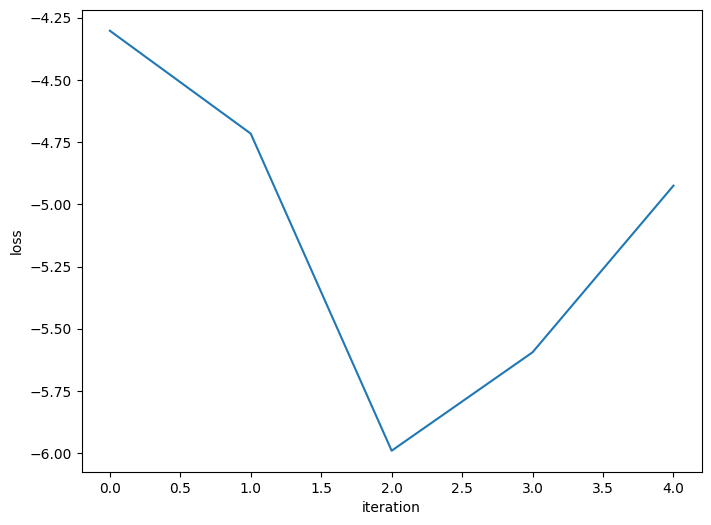

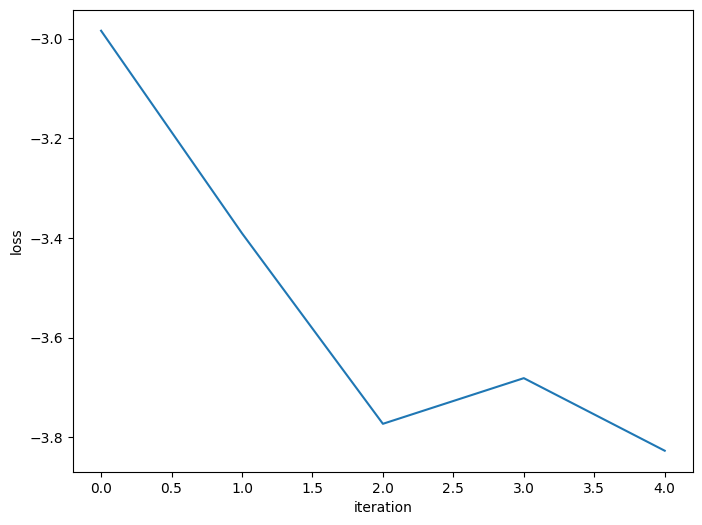

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -756.34223  validloss -620.78634±0.00000  bestvalidloss -620.78634  last_update 0
train: iter 1  trainloss -766.17774  validloss -638.58760±0.00000  bestvalidloss -638.58760  last_update 0
train: iter 2  trainloss -765.11522  validloss -649.81198±0.00000  bestvalidloss -649.81198  last_update 0
train: iter 3  trainloss -736.61265  validloss -368.91581±0.00000  bestvalidloss -649.81198  last_update 1
train: iter 4  trainloss -761.85231  validloss -644.69329±0.00000  bestvalidloss -649.81198  last_update 2
train: iter 5  trainloss -773.11428  validloss -637.55976±0.00000  bestvalidloss -649.81198  last_update 3
train: iter 6  trainloss -766.44698  validloss -630.28541±0.00000  bestvalidloss -649.81198  last_update 4
train: iter 7  trainloss -767.30696  validloss -656.99397±0.00000  bestvalidloss -656.99397  last_update 0
train: iter 8  trainloss -775.95670  validloss -619.07616±0.00000  bestvalidloss -656.99397  last_u

train: iter 76  trainloss -725.80757  validloss -644.21183±0.00000  bestvalidloss -699.69883  last_update 9
train: iter 77  trainloss -752.46875  validloss -607.03189±0.00000  bestvalidloss -699.69883  last_update 10
train: iter 78  trainloss -779.00514  validloss -686.23720±0.00000  bestvalidloss -699.69883  last_update 11
train: iter 79  trainloss -780.31050  validloss -679.16206±0.00000  bestvalidloss -699.69883  last_update 12
train: iter 80  trainloss -776.09295  validloss -625.07065±0.00000  bestvalidloss -699.69883  last_update 13
train: iter 81  trainloss -778.82494  validloss -660.89303±0.00000  bestvalidloss -699.69883  last_update 14
train: iter 82  trainloss -778.38381  validloss -664.59521±0.00000  bestvalidloss -699.69883  last_update 15
train: iter 83  trainloss -777.10074  validloss -678.03820±0.00000  bestvalidloss -699.69883  last_update 16
train: iter 84  trainloss -769.88437  validloss -617.22764±0.00000  bestvalidloss -699.69883  last_update 17
train: iter 85  trai

train: iter 151  trainloss -777.28820  validloss -686.68224±0.00000  bestvalidloss -706.85833  last_update 35
train: iter 152  trainloss -786.81378  validloss -666.43483±0.00000  bestvalidloss -706.85833  last_update 36
train: iter 153  trainloss -777.69812  validloss -672.97775±0.00000  bestvalidloss -706.85833  last_update 37
train: iter 154  trainloss -789.66812  validloss -641.70526±0.00000  bestvalidloss -706.85833  last_update 38
train: iter 155  trainloss -790.70604  validloss -647.20974±0.00000  bestvalidloss -706.85833  last_update 39
train: iter 156  trainloss -797.51707  validloss -681.58679±0.00000  bestvalidloss -706.85833  last_update 40
train: iter 157  trainloss -798.25525  validloss -684.09158±0.00000  bestvalidloss -706.85833  last_update 41
train: iter 158  trainloss -753.75701  validloss -687.62739±0.00000  bestvalidloss -706.85833  last_update 42
train: iter 159  trainloss -738.15046  validloss -626.15133±0.00000  bestvalidloss -706.85833  last_update 43
train: ite

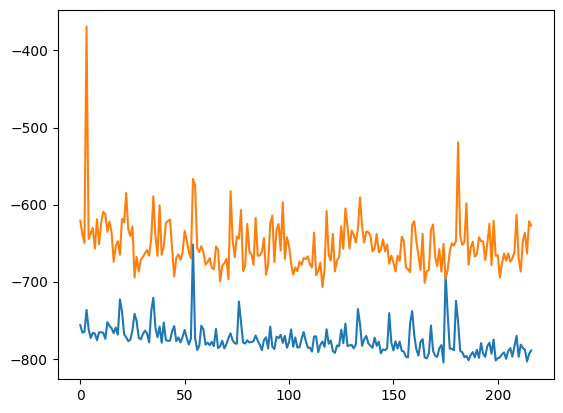

alpha 0.2 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-16 10:48:02.844698


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.55718  validloss 0.70459±0.00000  bestvalidloss 0.70459  last_update 0
train: iter 1  trainloss 0.50176  validloss 0.61817±0.00000  bestvalidloss 0.61817  last_update 0
train: iter 2  trainloss 0.49056  validloss 0.60205±0.00000  bestvalidloss 0.60205  last_update 0
train: iter 3  trainloss 0.47849  validloss 0.59816±0.00000  bestvalidloss 0.59816  last_update 0
train: iter 4  trainloss 0.47706  validloss 0.61682±0.00000  bestvalidloss 0.59816  last_update 1
train: iter 5  trainloss 0.46620  validloss 0.58699±0.00000  bestvalidloss 0.58699  last_update 0
train: iter 6  trainloss 0.46631  validloss 0.57869±0.00000  bestvalidloss 0.57869  last_update 0
train: iter 7  trainloss 0.47154  validloss 0.61574±0.00000  bestvalidloss 0.57869  last_update 1
train: iter 8  trainloss 0.46615  validloss 0.58078±0.00000  bestvalidloss 0.57869  last_update 2
train: iter 9  trainloss 0.45942  validloss 0.58853±0.00000  bestvalidloss 0.57869  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.43590  validloss 0.65490±0.00000  bestvalidloss 0.57835  last_update 62
train: iter 84  trainloss 0.42653  validloss 0.61984±0.00000  bestvalidloss 0.57835  last_update 63
train: iter 85  trainloss 0.43147  validloss 0.62417±0.00000  bestvalidloss 0.57835  last_update 64
train: iter 86  trainloss 0.43366  validloss 0.61908±0.00000  bestvalidloss 0.57835  last_update 65
train: iter 87  trainloss 0.43021  validloss 0.64740±0.00000  bestvalidloss 0.57835  last_update 66
train: iter 88  trainloss 0.43775  validloss 0.59852±0.00000  bestvalidloss 0.57835  last_update 67
train: iter 89  trainloss 0.43139  validloss 0.65004±0.00000  bestvalidloss 0.57835  last_update 68
train: iter 90  trainloss 0.42689  validloss 0.58886±0.00000  bestvalidloss 0.57835  last_update 69
train: iter 91  trainloss 0.43253  validloss 0.60976±0.00000  bestvalidloss 0.57835  last_update 70
train: iter 92  trainloss 0.43085  validloss 0.60194±0.00000  bestvalidloss 0.57835  last_update 71


([0.5571822937577963,
  0.50176224950701,
  0.4905617178417742,
  0.4784914517775178,
  0.47705650590360166,
  0.4662037657573819,
  0.4663140332326293,
  0.47153804879635575,
  0.46615441525354984,
  0.45941512789577243,
  0.45888957642018796,
  0.461411967035383,
  0.45935562439262867,
  0.45200776886194943,
  0.4584354146383703,
  0.45781092885881663,
  0.45666771503165365,
  0.45432040812447666,
  0.455325148999691,
  0.4474107906222343,
  0.44616329213604333,
  0.4598681839182973,
  0.44990053717046974,
  0.45000122040510177,
  0.4482245394028723,
  0.4492150699719787,
  0.4460337867029011,
  0.44179639890789985,
  0.44803944090381265,
  0.45775083992630244,
  0.44552690638229253,
  0.44491004589945077,
  0.4499715818092227,
  0.4442591849714518,
  0.4425431231036782,
  0.44515974195674063,
  0.43817809475585817,
  0.44490718375891447,
  0.4501430937089026,
  0.440887569822371,
  0.4436278241686523,
  0.43686336614191534,
  0.4468152690678835,
  0.44852574048563837,
  0.4399780132

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.918300162139536
valid_loss:  -7.971113992881774
weight_alpha 1.0 h_min_tilde -11.495488 ell_tilde -7.928862928287983 kappa_tilde 0.00026475322871437237
train_loss:  -4.145042105531692
valid_loss:  -3.4961957660675047
weight_alpha 0.2 h_min_tilde -11.495488 ell_tilde -4.015272837638855 kappa_tilde 0.00018281547466673188


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 112.07942  validloss 123.43213±0.00000  bestvalidloss 123.43213  last_update 0
train: iter 1  trainloss 91.12785  validloss 97.49533±0.00000  bestvalidloss 97.49533  last_update 0
train: iter 2  trainloss 75.77151  validloss 80.87337±0.00000  bestvalidloss 80.87337  last_update 0
train: iter 3  trainloss 62.54930  validloss 67.33957±0.00000  bestvalidloss 67.33957  last_update 0
train: iter 4  trainloss 53.05761  validloss 55.05854±0.00000  bestvalidloss 55.05854  last_update 0
train: iter 5  trainloss 44.98290  validloss 46.87918±0.00000  bestvalidloss 46.87918  last_update 0
train: iter 6  trainloss 39.18278  validloss 38.71451±0.00000  bestvalidloss 38.71451  last_update 0
train: iter 7  trainloss 33.98742  validloss 32.26193±0.00000  bestvalidloss 32.26193  last_update 0
train: iter 8  trainloss 29.63758  validloss 27.47869±0.00000  bestvalidloss 27.47869  last_update 0
train: iter 9  trainloss 26.35333  validloss 24.42532±0.00000  bestvalidloss 24.42532  l

train: iter 85  trainloss 1.52426  validloss 0.85719±0.00000  bestvalidloss 0.78056  last_update 1
train: iter 86  trainloss 1.48364  validloss 0.81239±0.00000  bestvalidloss 0.78056  last_update 2
train: iter 87  trainloss 1.47171  validloss 0.78844±0.00000  bestvalidloss 0.78056  last_update 3
train: iter 88  trainloss 1.39010  validloss 0.80615±0.00000  bestvalidloss 0.78056  last_update 4
train: iter 89  trainloss 1.37900  validloss 0.75366±0.00000  bestvalidloss 0.75366  last_update 0
train: iter 90  trainloss 1.34574  validloss 0.78244±0.00000  bestvalidloss 0.75366  last_update 1
train: iter 91  trainloss 1.30419  validloss 0.70943±0.00000  bestvalidloss 0.70943  last_update 0
train: iter 92  trainloss 1.27096  validloss 0.68009±0.00000  bestvalidloss 0.68009  last_update 0
train: iter 93  trainloss 1.23960  validloss 0.58038±0.00000  bestvalidloss 0.58038  last_update 0
train: iter 94  trainloss 1.19180  validloss 0.62619±0.00000  bestvalidloss 0.58038  last_update 1
train: ite

train: iter 167  trainloss 0.65426  validloss 0.42488±0.00000  bestvalidloss 0.38665  last_update 29
train: iter 168  trainloss 0.66383  validloss 0.42610±0.00000  bestvalidloss 0.38665  last_update 30
train: iter 169  trainloss 0.67128  validloss 0.52244±0.00000  bestvalidloss 0.38665  last_update 31
train: iter 170  trainloss 0.64479  validloss 0.44686±0.00000  bestvalidloss 0.38665  last_update 32
train: iter 171  trainloss 0.64255  validloss 0.43078±0.00000  bestvalidloss 0.38665  last_update 33
train: iter 172  trainloss 0.64976  validloss 0.49461±0.00000  bestvalidloss 0.38665  last_update 34
train: iter 173  trainloss 0.65751  validloss 0.45226±0.00000  bestvalidloss 0.38665  last_update 35
train: iter 174  trainloss 0.65891  validloss 0.45948±0.00000  bestvalidloss 0.38665  last_update 36
train: iter 175  trainloss 0.66462  validloss 0.48165±0.00000  bestvalidloss 0.38665  last_update 37
train: iter 176  trainloss 0.65430  validloss 0.44489±0.00000  bestvalidloss 0.38665  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.9504, -1.5058, -2.2053, -2.5060], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 6.15545  validloss 39.14812±0.00000  bestvalidloss 39.14812  last_update 0
train: iter 1  trainloss 6.01617  validloss 39.36933±0.00000  bestvalidloss 39.14812  last_update 1
train: iter 2  trainloss 5.93296  validloss 39.63737±0.00000  bestvalidloss 39.14812  last_update 2
train: iter 3  trainloss 6.00447  validloss 43.66835±0.00000  bestvalidloss 39.14812  last_update 3
train: iter 4  trainloss 5.94852  validloss 41.04994±0.00000  bestvalidloss 39.14812  last_update 4
train: iter 5  trainloss 5.92103  validloss 36.16206±0.00000  bestvalidloss 36.16206  last_update 0
train: iter 6  trainloss 5.96299  validloss 38.38317±0.00000  bestvalidloss 36.16206  last_update 1
train: iter 7  trainloss 5.91978  validloss 39.98883±0.00000  bestvalidloss 36.16206  last_update 2
train: iter 8  trainloss 5.92079  validloss 39.23593±0.00000  bestvalidloss 36.16206  last_update 3
train: iter 9  trainloss 5.90808  validloss 36.19477±0.00000  bestvalidloss 36.16206  last_update 4


train: iter 81  trainloss 5.77546  validloss 36.44373±0.00000  bestvalidloss 32.36414  last_update 23
train: iter 82  trainloss 5.78125  validloss 40.30014±0.00000  bestvalidloss 32.36414  last_update 24
train: iter 83  trainloss 5.80950  validloss 36.71667±0.00000  bestvalidloss 32.36414  last_update 25
train: iter 84  trainloss 5.85782  validloss 40.20959±0.00000  bestvalidloss 32.36414  last_update 26
train: iter 85  trainloss 5.79726  validloss 37.89779±0.00000  bestvalidloss 32.36414  last_update 27
train: iter 86  trainloss 5.78288  validloss 37.85645±0.00000  bestvalidloss 32.36414  last_update 28
train: iter 87  trainloss 5.78838  validloss 37.17358±0.00000  bestvalidloss 32.36414  last_update 29
train: iter 88  trainloss 5.77861  validloss 36.01957±0.00000  bestvalidloss 32.36414  last_update 30
train: iter 89  trainloss 5.79312  validloss 36.67498±0.00000  bestvalidloss 32.36414  last_update 31
train: iter 90  trainloss 5.76202  validloss 37.51388±0.00000  bestvalidloss 32.36

train: iter 162  trainloss 5.73375  validloss 41.95454±0.00000  bestvalidloss 32.22140  last_update 62
train: iter 163  trainloss 5.72125  validloss 39.80444±0.00000  bestvalidloss 32.22140  last_update 63
train: iter 164  trainloss 5.69691  validloss 40.43368±0.00000  bestvalidloss 32.22140  last_update 64
train: iter 165  trainloss 5.75475  validloss 36.18063±0.00000  bestvalidloss 32.22140  last_update 65
train: iter 166  trainloss 5.72069  validloss 36.40810±0.00000  bestvalidloss 32.22140  last_update 66
train: iter 167  trainloss 5.74279  validloss 39.12576±0.00000  bestvalidloss 32.22140  last_update 67
train: iter 168  trainloss 5.74022  validloss 35.73367±0.00000  bestvalidloss 32.22140  last_update 68
train: iter 169  trainloss 5.73749  validloss 36.48890±0.00000  bestvalidloss 32.22140  last_update 69
train: iter 170  trainloss 5.68944  validloss 32.99588±0.00000  bestvalidloss 32.22140  last_update 70
train: iter 171  trainloss 5.68076  validloss 37.06152±0.00000  bestvalid

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-5.2668)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.4764)


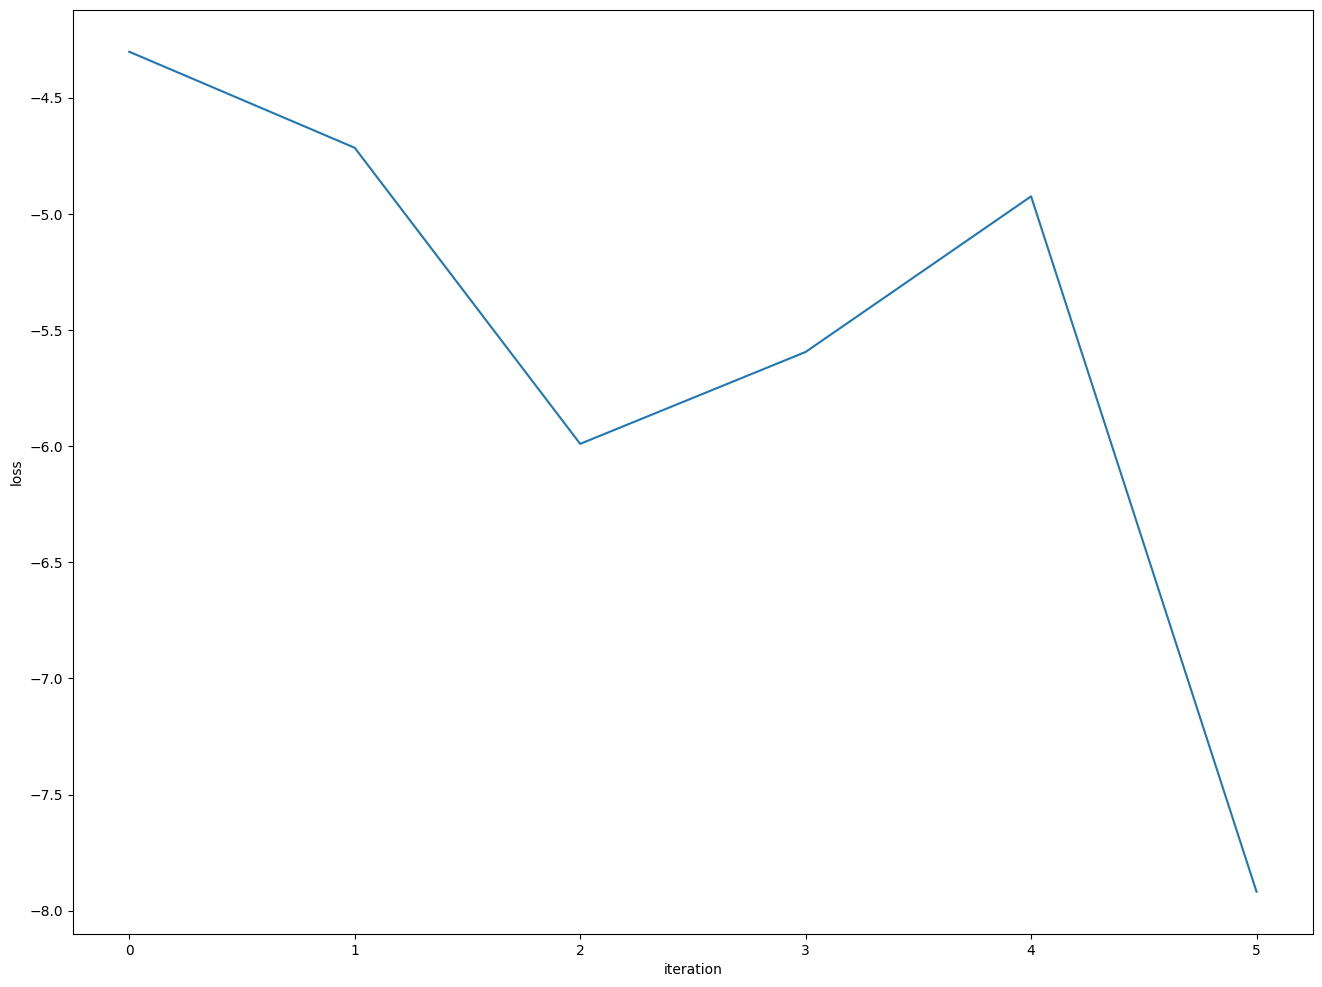

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

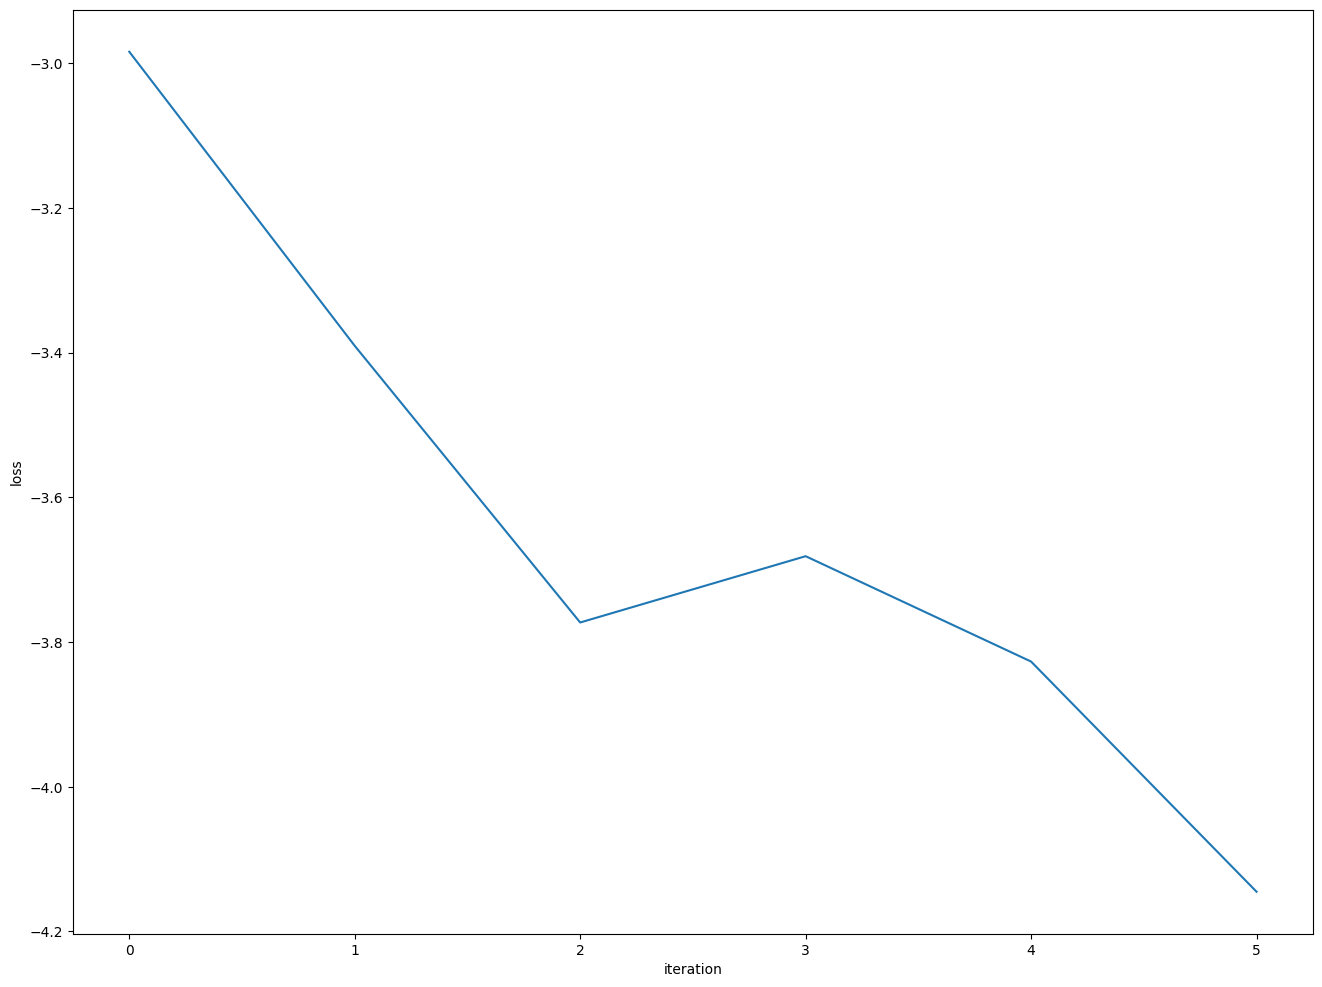

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")